# 들어가며

코로나가 국내에서 시작되고 어느덧 반년이 지났습니다. 코로나가 장기화되면서, 이제 계속 해야 할 고민은 **"전염병에 대한 올바른 대처를 하면서, 어떻게 하면 전염병이 없었던 때처럼 경제 활동을 할 수 있을까?"** 라고 생각합니다. 코로나로 인한 생명의 위협보다도, 매출에 대한 걱정, 미래에 대한 불투명성 등 경제적, 진로적인 어려움으로 인한 두려움이 훨씬 더 커진 것이 아닌가 싶습니다. 이 물음을 기저로 하는 인사이트 발굴과, 조금이나마 도움이 될 수 있는 제안을 하는 것에 신경을 썼고, 부족한 점이 많은 글이지만 읽어주시면 감사하겠습니다! 


## 목차


--**Analysis**--  
1.주요 소비 패턴 파악을 위한 각 업종의 판매건수 클러스터링  
2.유동인구와 판매건수의 관계 파악 및 회복 기간 계산

--**Insight**--  
1.보복성 소비: 주요 소비의 증가는 지속될 수 있을까?    
2.소수에게만 해당되는 '배달'이라는 돌파구  
3.소비의 양극화  
4.희비교차가 엇갈리는 온라인 산업과 오프라인 산업    
&nbsp;&nbsp;&nbsp;  4.1.대확산 시기, 홀로 우뚝 선 비대면 상거래 업종    
&nbsp;&nbsp;&nbsp;  4.2.회복이 더딘 대표 오프라인 산업들    

--**Suggestion**--  
1.인사이트에서 얻은 물음의 답: 라이브 카머스  
2.라이브 카머스의 활용 방안    
&nbsp;&nbsp;&nbsp; 2.1.손바닥 화개장터    
&nbsp;&nbsp;&nbsp; 2.2.Live Korea Market    

참고문헌



## 데이터

- card_20200717.csv
- adstrd_master.csv
- fpopl.csv
- delivery.csv

외부 데이터는 다음과 같습니다.
- 외래객입국_목적별.xlsx: [한국관광 통계자료 검색](http://kto.visitkorea.or.kr/kor/ktom/stat/stat.kto)에서 **외래객입국>목적별** 카테고리에서, **기준:월, 시점: 2020년 1월부터 2020년 5월까지** 조회.
- 외래객입국_목적별_국적별.xlsx: [한국관광 통계자료 검색](http://kto.visitkorea.or.kr/kor/ktom/stat/stat.kto)에서 **외래객입국>목적별/국적별** 카테고리에서, **기준:월, 시점: 2019년 1월부터 2020년 5월까지** 조회
- 관광수지_관광수입.xlsx: [한국관광 통계자료 검색](http://kto.visitkorea.or.kr/kor/ktom/stat/stat.kto)에서 **관광수지>관광수입** 카테고리에서, **기준:월, 시점: 2019년 1월부터 2020년 5월까지** 조회
- datalab.xlsx: [네이버 검색어 트렌드](https://datalab.naver.com/keyword/trendResult.naver?hashKey=N_2e3ae942ad325329a02965c8cbdf71ea)에서 다음과 같이 조회.
 - **주제어1**:인터넷 쇼핑 
 - **모든 검색어**: 쿠팡,위메프,11번가,g마켓,ssg닷컴,옥션,인터파크,네이버쇼핑,마켓컬리 
 - **기간**: 2019년 1월 10일부터 2020년 6월 20일
 - **연령선택**: 40~44부터 끝까지
- datalab (1).xlsx: [네이버 검색어 트렌드](https://datalab.naver.com/keyword/trendResult.naver?hashKey=N_430162226f30e7221f31b591fa843173)에서 다음과 같이 조회.
 - **주제어1** OTT 
 - **모든 검색어**: 넷플릭스, 왓챠, 티빙, 네이버tv
 - **기간**: 2019년 1월 10일부터 2020년 6월 20일
 - **연령선택**: 19~24부터 끝까지
---

In [1]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import csv
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
#Matplotlib 한국어 세팅
import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\malgun.ttf').get_name()
    rc('font', family=font_name)

In [3]:
#palette
pal = ['#50d890', '#007944','#888888','#f3c623','#EFEFEF', '#96bb7c', '#d9bf77','#3f3f44']

In [4]:
card = pd.read_csv('data/card_20200717.csv')
region = pd.read_csv('data/adstrd_master.csv', encoding='UTF-8')
fpopl = pd.read_csv('data/fpopl.csv')
delivery = pd.read_csv('data/delivery.csv')

tour_num = pd.read_excel('data/외래객입국_목적별.xlsx',encoding='UTF-8') #한국관광 통계자료 검색(목적별)
tour_nation = pd.read_excel('data/외래객입국_목적별_국적별.xlsx',encoding='UTF-8') #한국관광 통계자료 검색(목적별_국적별)
tour_money = pd.read_excel('data/관광수지_관광수입.xlsx',encoding='UTF-8') #한국관광 통계자료 검색(관광수지_관광수입)
search_online = pd.read_excel('data/datalab.xlsx', encoding='UTF-8', header=6) #네이버 데이터랩 검색어 트렌드(e-commerce)
search_ott = pd.read_excel('data/datalab (1).xlsx', encoding='UTF-8', header=6) #네이버 데이터랩 검색어 트렌드(OTT)

---

# ANALYSIS

---

# 1. 주요 소비 패턴 파악을 위한 각 업종의 판매건수 클러스터링

card_20200717.csv 데이터의 전처리 및 판매건수 클러스터링을 진행했습니다.

### 전처리1: 날짜별, 업종별 합

In [5]:
card.columns = ['날짜', '행정동 코드', '행정동', '업종 코드', '업종', '판매건수', '판매금액']
card['날짜'] = card['날짜'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
card['행정동 코드'] = card['행정동 코드'].astype('str').apply(lambda x: x[:-2]).astype('int')

In [6]:
region.columns = ['행정동 코드', '행정동', '광역시도', '시군구']
region['행정동 코드'] = region['행정동 코드'].astype('int')
card = pd.merge(card, region, on=['행정동 코드'],how='left')

card = card[card['광역시도']=='서울특별시'] #지역은 서울특별시로 한정.
card = card.drop(['행정동 코드', '업종 코드'],axis=1)
card = card.groupby(['날짜','업종']).sum().reset_index()

### 전처리2: 각 날짜에 업종이 안 존재하는 경우는, 해당 업종의  판매건수와 판매금액이 0인경우로 판단하고 0을 삽입

In [7]:
date = list(card['날짜'].unique())
category = list(card['업종'].unique())
item = [date, category]

from itertools import product
card_temp = pd.DataFrame(product(*item), columns= ['날짜','업종'])

card = pd.merge(card,card_temp,on=['날짜','업종'], how='right')
card = card.fillna(0)
card = card.groupby(['날짜','업종']).mean().reset_index() # 날짜별로 업종이 가나다 순서대로 정렬되는 효과. 그 외에 아무것도 안바뀜.

### 전처리3: 각 업종의 판매건수와 판매금액의 주간 평균 구하기

일별로 판매금액을 보는 경우, 주간 Trend가 명확하고 노이즈가 존재했기 때문에, 전반적인 트렌드를 보고자 주간 평균으로 보는 것으로 결정했습니다.


In [8]:
card_compare = card.copy()
import datetime as dt

card['주'] = pd.to_datetime(card['날짜']).dt.week #주 변수 추가
card = card.groupby(['업종','주']).mean().reset_index()

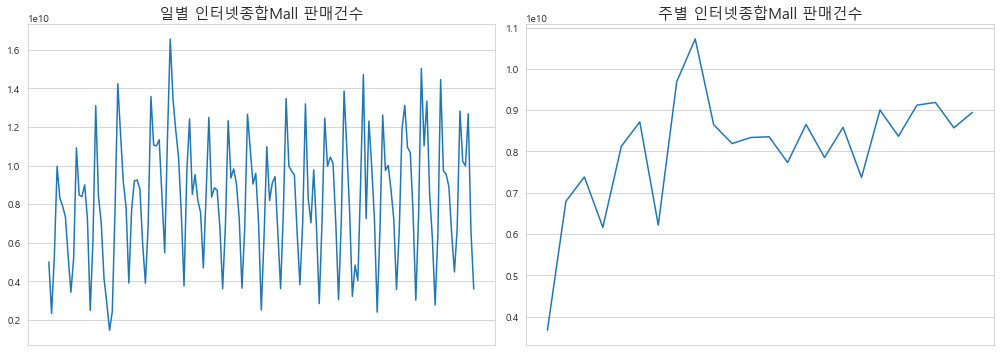

In [9]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(card_compare[card_compare['업종'] == '인터넷종합Mall']['판매금액'])
ax[0].set_title("일별 인터넷종합Mall 판매건수", fontsize=15)
ax[0].set_xticks([])
ax[1].plot(card[card['업종'] == '인터넷종합Mall']['판매금액'])
ax[1].set_title("주별 인터넷종합Mall 판매건수", fontsize=15)   
ax[1].set_xticks([])
plt.tight_layout()

### 전처리4: 1,2,3주에 해당하는 데이터 제거

대부분의 업종에서 1,2,3주가 데이터 누락으로 추정되는 경우가 존재하기에 1,2,3주는 분석에 앞서 제외하였습니다. 1,2,3 주를 포함한 상태에서 클러스터링을 하는 경우, 대부분의 업종에서 1,2,3주에서 최하점을 찍는 경향이 있기 때문에 군집이 잘 못 형성될 가능성이 있다고 생각하였습니다. 

In [10]:
card_temp = card.copy()
card_temp['판매건수'] = card.groupby('업종')['판매건수'].transform(lambda x: (x-x.min())/(x.max() - x.min()))

front_week = card_temp[(card_temp['주'].isin([1,2,3]))]
behind_week = card_temp[~(card_temp['주'].isin([1,2,3]))]
k1=front_week.groupby(['업종']).mean()['판매건수'].median(); k2=behind_week.groupby(['업종']).mean()['판매건수'].median()

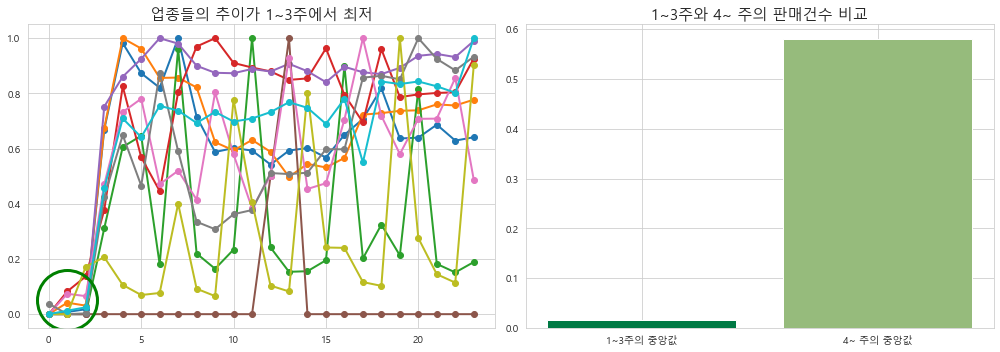

In [11]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
kind = list(card['업종'].unique())
 
for i in range(0, len(set(card_temp['업종']))):
    if i//10 == 0:
        ax[0].plot(np.array(card_temp[card_temp['업종'] == kind[i]]['판매건수']),marker='o', linewidth=2)
ax[0].set_title('업종들의 추이가 1~3주에서 최저', fontsize=15)
ax[0].plot(1, 0.05, 'o', ms=60, mfc='none', color='g', mew=3)
        
x=['1~3주의 중앙값', '4~ 주의 중앙값']
y=[k1,k2]
ax[1].bar(x, y,  color=[pal[1],pal[5]])
ax[1].set_title("1~3주와 4~ 주의 판매건수 비교", fontsize=15)

plt.tight_layout()

In [12]:
card = card[~card['주'].isin([1,2,3])].reset_index(drop=True)

### 클러스터링에서 제외한 업종1: 주기적인 소비 패턴을 가지는 업종

한달에 한번 내는 등의 주기적인 소비 특징을 가지고 있는 업종들, 또는 모든 기간 판매건수가 0인 업종은 관심사가 아니므로 클러스터링에서 제외하였습니다. --> Correlation의 hierarchical_clustering 후 소비패턴이 주기적인 특성을 갖는 클러스터 삭제

In [13]:
corr = pd.pivot(card, index='주', columns='업종', values='판매건수').corr()
temp = corr.isnull().sum()
temp[temp > 2]

업종
비씨카드정산용(할인)    260
카지노            260
dtype: int64

In [14]:
#모든 주에 판매건수, 판매금액 평균이 0이어서 correlation이 계산되지 않으므로 제거한다.
card = card[~card['업종'].isin(list(temp[temp > 2].index))].reset_index(drop=True)

In [15]:
import scipy.cluster.hierarchy as spc
def hierarchical_clustering(correlation, method, param): 
    pdist = spc.distance.pdist(correlation)
    linkage = spc.linkage(pdist, method=method)
    idx = spc.fcluster(linkage, param * pdist.max(), 'distance')
    cluster = pd.DataFrame({'업종':correlation.index, '그룹':idx})   
    return cluster

In [16]:
#업종별로 MinMax Scaling하는 함수
def get_scale(Data, target1, target2):
    Data[target1 + "_sc"] = np.zeros(Data.shape[0])
    Data[target1 + "_sc"] = np.zeros(Data.shape[0])
    
    for kind in Data['업종'].unique():
        temp = Data[Data['업종'] == kind].copy()
        temp[target1 + "_sc"]  = temp[target1].transform(lambda x:(x-x.min())/(x.max()-x.min()))
        temp[target2 + "_sc"]  = temp[target2].transform(lambda x:(x-x.min())/(x.max()-x.min()))
        index = temp.index
        Data.loc[index,target1 + "_sc"] = temp[target1 + "_sc"]
        Data.loc[index,target2 + "_sc"] = temp[target2 + "_sc"]
    
    return Data

In [17]:
corr = pd.pivot(card, index='주', columns='업종', values='판매건수').corr()
cluster = hierarchical_clustering(corr, 'complete', 0.45)  

In [18]:
card = get_scale(card, '판매금액', '판매건수') 

10,11,12에 해당하는 클러스터들은 매우 판매건수가 주기적인 형태를 가지고 있거나, 특별한 트렌드가 없어서 클러스터링에 안 좋은 영향을 줄 것으로 판단되어 클러스터링에서 제외했습니다.

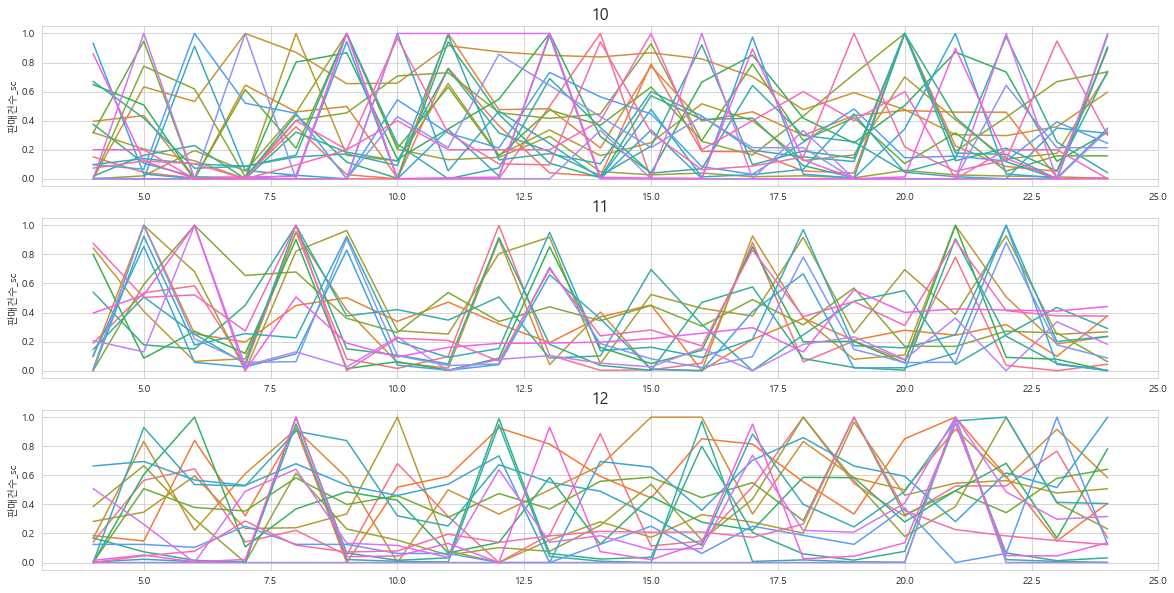

In [19]:
fig,ax = plt.subplots(3,1,figsize=(20,10))
for num,i in enumerate([10,11,12]):
    cluster_kind = list(cluster[cluster['그룹']==i]['업종'])
    temp = card[card['업종'].isin(cluster_kind)]
    sns.lineplot(temp['주'],temp['판매건수_sc'],hue=temp['업종'],ax=ax[num])
    ax[num].legend().set_visible(False); ax[num].set_xlabel('')
    ax[num].set_title(i, fontsize=16)

In [20]:
remove = []

for i in [11,10,12]:
    remove += list(cluster[cluster.그룹==i]['업종'])
    
#다만 콘도 , 택시, 대형할인점의 경우 해당 군집으로 분류되었지만 상식선에서 주기적인 지불 방식 업종이 아니므로 삭제 하지 않음.
remove.remove('콘   도')
remove.remove('택   시')
remove.remove('대형할인점')

### 전처리5: 이동평균 변수 추가 

더욱 robust한 트렌드를 보기 위해, 판매건수와 판매금액 모두 이동평균 변수를 추가하고 이동평균으로 클러스터링을 시도하였습니다.

In [21]:
card['이동평균_건수'] = card.groupby('업종').rolling(window=3, min_periods=1).mean().reset_index()['판매건수']
card['이동평균_금액'] = card.groupby('업종').rolling(window=3, min_periods=1).mean().reset_index()['판매금액']
card = get_scale(card, '이동평균_건수', '이동평균_금액')

In [22]:
card_new = card[~card['업종'].isin(remove)].reset_index(drop=True).copy()

### 클러스터링에서 제외한 업종2: 소수 소비 트렌드를 가진 업종

주요 소비 트렌드를 보는 것이 목적이기 때문에, 너무 동떨어져 있거나, 소수로 묶인 클러스터는 클러스터링에서 제외하였습니다.

In [23]:
corr_ma = pd.pivot(card_new[['업종','주','이동평균_건수']], index='주', columns='업종', values='이동평균_건수').corr()
cluster_ma = hierarchical_clustering(corr_ma, 'complete', 0.3)  

In [24]:
cluster_count = cluster_ma['그룹'].value_counts()
ind = cluster_count[cluster_count.values<=4].index 

In [25]:
#전반적인 트렌드를 보고자, 클러스터에서 튀는 업종 일부 추가적으로 제외
remove = ['법률회계서비스(개인)','법률회계서비스(법인)','일반 서적', '기타농업관련', '제과점', '미곡상', '세 차 장'] 

for i in ind:
    remove += list(cluster_ma[cluster_ma.그룹==i]['업종'])

In [26]:
card_new = card_new[~card_new['업종'].isin(remove)].reset_index(drop=True)

### 본격적인 클러스터링: Hierarchical + K-means Clustering

클러스터링에서 제외할 업종들을 모두 제외한 후, Hierarchial Clustering으로 각 업종의 판맨건수 추이를 군집화했습니다.

In [27]:
temp_ma = pd.pivot(card_new[['업종','주','이동평균_건수_sc']], index='주', columns='업종', values='이동평균_건수_sc').copy()

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage

corr_ma2 = pd.pivot(card_new[['업종','주','이동평균_건수']], index='주', columns='업종', values='이동평균_건수').corr()
pdist = spc.distance.pdist(corr_ma2)
linked = linkage(pdist, 'ward')

fig = ff.create_dendrogram(linked, color_threshold=125)
fig.update_layout(width=800, height=500)
fig.show()

적절한 군집수와 그 군집수를 형성하기위한 파라미터를 찾습니다. --> 군집은 9개로 결정했습니다.

In [29]:
corr_ma = pd.pivot(card_new[['업종','주','이동평균_건수']], index='주', columns='업종', values='이동평균_건수').corr()

param_list = [0.1, 0.2, 0.3, 0.4, 0.5,0.51,0.55,0.59,0.6, 0.7, 0.8, 0.9]
n_cluster = []
for i in param_list:
    pdist = spc.distance.pdist(corr_ma)
    linkage = spc.linkage(pdist, method='ward')
    idx = spc.fcluster(linkage, i * pdist.max(), 'distance')
    n_cluster.append(len(set(idx)))

In [30]:
corr_ma = pd.pivot(card_new[['업종','주','이동평균_건수']], index='주', columns='업종', values='이동평균_건수').corr()
cluster_ma = hierarchical_clustering(corr_ma, 'ward', param_list[np.where(np.array(n_cluster) == 9)[0][0]])  

### (3, 4, 9), (6, 8)만 다시 묶은 후, K-means로 세부 클러스터링

Correlation으로 hierarchical clustering을 하면, 추이는 반영하지만 거리가 반영이 덜 되는 점이 아쉬웠습니다. 구체적으로, (3,4,9)의 경우 11주(대확산 시기) 이전의 부분이 클러스터링이 선명하게 되지 못하는 경향을 보였고, (6,8)의 경우에는 6이 8과 겹치는 부분이 많다고 판단했습니다. 따라서, 조금 더 확실한 클러스터링을 위해 추가적으로, 이번에는 Correlation 대신 스케일링된 이동평균 판매건수 값으로 K-means를 이용하여 세부 클러스터링을 진행했습니다. 

In [31]:
def additional_clustering(Card, cluster_used, List, n_clusters, Week):
    cluster_temp = list(set(cluster_used[cluster_used['그룹'].isin(List)]['업종']))
    temp = Card[Card['업종'].isin(cluster_temp)].reset_index(drop=True).copy()
    temp = temp[temp['주'] < Week]
    temp_ma = pd.pivot(temp[['업종','주','이동평균_건수_sc']], index='주', columns='업종', values='이동평균_건수_sc')
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(temp_ma.T)
    
    List.append(0)
    strings = [str(integer) for integer in List]
    a_string = "". join(strings)
    an_integer = int(a_string)
    idx = kmeans.labels_ + an_integer
    
    cluster_ma = pd.DataFrame({'업종':temp_ma.columns, '그룹':idx})
    
    return cluster_ma

In [32]:
cluster_ma349 = additional_clustering(card_new, cluster_ma, List = [3, 4, 9], n_clusters = 3, Week=999)
cluster_ma68 = additional_clustering(card_new, cluster_ma, List = [6, 8], n_clusters = 2, Week=11)

In [33]:
cluster_ma = cluster_ma[~cluster_ma['그룹'].isin([3,4,9])].reset_index(drop=True)
cluster_ma = pd.concat([cluster_ma, cluster_ma349]).reset_index(drop=True)

In [34]:
cluster_ma = cluster_ma[~cluster_ma['그룹'].isin([6,8])].reset_index(drop=True)
cluster_ma = pd.concat([cluster_ma, cluster_ma68]).reset_index(drop=True)

In [35]:
shape = {3492:'증가형태1', 681:'증가형태2', 5:'증가형태3', 680:'증가형태4',3490:'굴곡형태1',3491:'굴곡형태2',1:'굴곡형태3',2:'감소형태1'}
cluster_ma['형태'] = cluster_ma['그룹'].replace(shape)
cluster_ma = cluster_ma.copy()
category = shape.values()

#최종 클러스터 결과
@interact
def show(col=category):
    fig = go.Figure()
    cluster_kind = list(cluster_ma[cluster_ma['형태']==col]['업종'])
    temp_final = card_new[card_new['업종'].isin(cluster_kind)]
    fig=px.line(temp_final, x='주', y='이동평균_건수_sc', color='업종', hover_data=['업종'])
    fig.update_layout(title = '각 업종의 판매건수 추이 클러스터', template='plotly_white',height=450)
    fig.show()

interactive(children=(Dropdown(description='col', options=('증가형태1', '증가형태2', '증가형태3', '증가형태4', '굴곡형태1', '굴곡형태2…

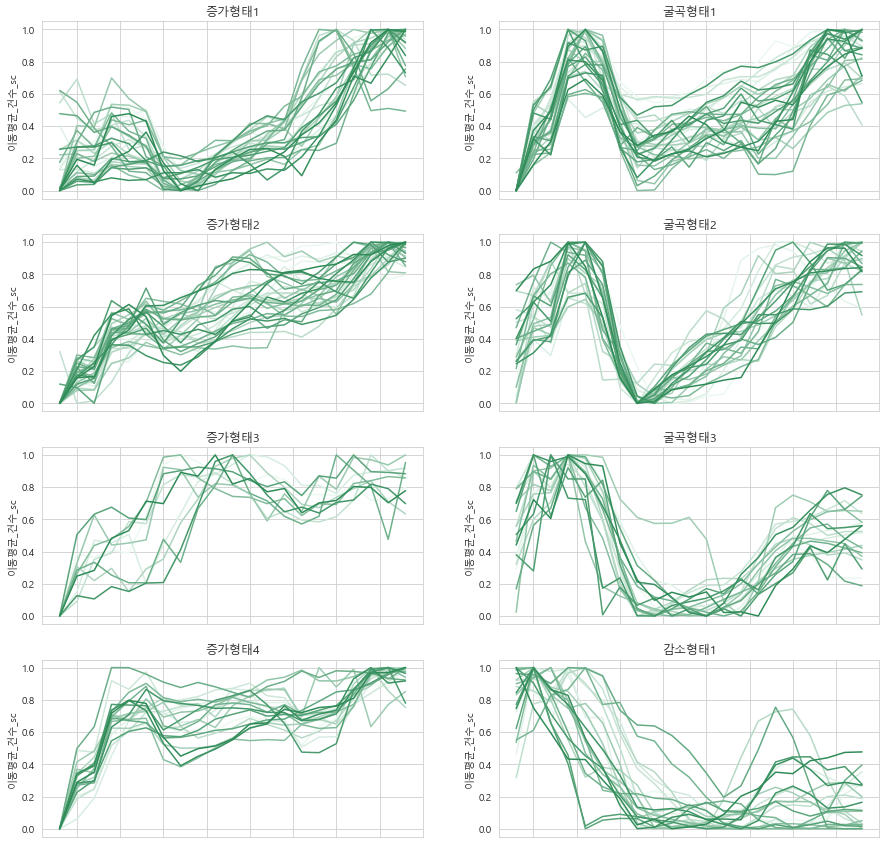

In [36]:
fig, ax =plt.subplots(4,2,figsize=(15,15))

for num, i in enumerate(category):
    if num<4: j=0
    else: 
        j=1; num=num-4
    cluster_kind = list(cluster_ma[cluster_ma['형태']==i]['업종'])
    temp_final = card_new[card_new['업종'].isin(cluster_kind)].copy()
    sns.lineplot(x="주", y="이동평균_건수_sc", hue="업종", data=temp_final, ax=ax[num,j], 
                 palette=sns.light_palette('seagreen', temp_final['업종'].nunique()))
    ax[num,j].legend().set_visible(False)
    ax[num,j].set_xticklabels([]); ax[num,j].set_xlabel('')
    ax[num,j].set_title(i)

위 클러스터들을 보면, 증가형태2,3,4의 경우 다른 클러스터에 비해 코로나에 의한 큰 타격이 있는 것으로 보이지 않고 판매건수가 증가하는 추세에 해당합니다. 한편, 증가형태1, 굴곡형태1,2,3, 감소형태1은 모두 코로나에 의해 작든 크든 타격을 받은 것으로 보이고, 그 회복추세도 상이합니다. 

그런데, 해당 Card 데이터는 대체로 오프라인 매장에 대한 판매건수 데이터이기 때문에, 상식적으로 **유동인구**와 깊은 관련이 있을 것이라 판단됩니다. 따라서, **이 클러스터 결과에서 나아가, 유동인구와 판매건수의 관계를 살펴보고, 관계가 있다면 유동인구의 회복추세와 각 업종들의 회복추세를 수치적으로 비교해보고자 합니다.**

### 트렌드 플롯 함수 정의

In [37]:
def plot_trend(ind, color='green',title='text', amount=False, legend=True):
    
    card_ind = card_new[card_new['업종'].isin(ind)]
    num_category = len(ind)
    
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    
    if amount==False:
        sns.lineplot(x='주', y='이동평균_건수_sc', data=card_ind, hue='업종',marker='>',linewidth=2, 
                palette=sns.light_palette("gray", num_category), ax=ax)
        sns.lineplot(x='주',y='이동평균_건수_sc', data=card_ind, ci='sd', color=color, alpha=0.1, ax=ax)
        plt.ylabel('이동평균_건수_sc')
        plt.title('판매건수 트렌드('+title+')', fontsize=18, weight='bold')
    else:
        sns.lineplot(x='주', y='이동평균_금액_sc', data=card_ind, hue='업종',marker='>',linewidth=2, 
                palette=sns.light_palette("gray", num_category), ax=ax)
        sns.lineplot(x='주',y='이동평균_금액_sc', data=card_ind, ci='sd', color=color, alpha=0.1, ax=ax)
        plt.ylabel('이동평균_금액_sc')
        plt.title('판매금액 트렌드('+title+')', fontsize=18, weight='bold')
    
    ax.axvline(11, c='darkgray')
    ax.text(11, 1.03, '2/24~3/15\n대확산', horizontalalignment='center', fontdict={'color':'gray', 'weight':'bold', 'size':13})
    ax.axvline(4, c='darkgray')
    ax.text(4, 1.03, '1/20~1/26\n설날', horizontalalignment='center', fontdict={'color':'gray', 'weight':'bold', 'size':13})
    
    if legend==True:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(loc='lower right', handles=handles[1:], frameon=False, bbox_to_anchor=(1.15, 0.2), fontsize=12, 
              title='주요 업종', title_fontsize=12)
    else:
        ax.legend().set_visible(False)
    plt.xlabel('이동평균 주', fontsize=13)
    plt.xticks(list(range(4,25)))
    plt.ylim(-0.05, 1.13)
    plt.xlim(3,25)
    plt.tight_layout()

In [38]:
#각 클러스터에서 많이 포진한 관련 있는 업종들
ind1_1 = ['가   방', '기타의류', '미 용 원', '일반백화점', '정장', '피부미용실']
ind1_2 = ['스포츠의류', '아동의류', '캐쥬얼의류', '와이셔츠/타이', '신   발', '제 화 점', '내의판매점']
ind2_1 = ['일반한식', '일식회집',  '서양음식', '중국음식', '주점']
ind2_2 = ['건축요업품',  '기타건축자재', '대형할인점',  '보일러펌프샷시', '수입자동차', '스크린골프']
ind2_3 = ['골프 용품', '골프경기장', '골프연습장', '기타주방용구', '냉열 기기', '일반 가구', '주방 용구', '주류판매점', '철제 가구']
ind3_1 = ['CATV홈쇼핑', '인터넷P/G', '인터넷종합Mall', '통신판매1']
ind3_2 = ['1급 호텔', '2급 호텔', '고속 버스', '기타숙박업', '문화취미기타']
ind3_3 =  ['기념품 점', '면 세 점', '사우나', '수 영 장','영화관', '외국인전용가맹점', '기타레져업', '특급 호텔', '항 공 사']

---

# 2. PCA를 이용한 유동인구와 판매건수의 관계 파악 및 각각의 회복 기간 계산

먼저, 유동인구도 마찬가지로 이동평균 주에 따른 추이를 살펴보았습니다. 그 결과, 유동인구 역시 이동평균 주 11주를 지난 뒤로 선형적으로 증가하여 코로나 이전보다도 회복하는 모습입니다. 그렇다면 실제로 유동인구가 판매건수를 얼마나 설명하는지를 수치적으로 확인하기로 했습니다.

In [39]:
fpopl.columns = ['날짜','시간','성별','연령','행정동 코드','인구수']

remove = ['age_00','age_10','age_15','age_70'] #20대~60대만 확인
fpopl = fpopl[~fpopl['연령'].isin(remove)]

fpopl['날짜'] = fpopl['날짜'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
fpopl = fpopl.groupby('날짜').sum().reset_index().drop(['시간','행정동 코드'], axis=1)
fpopl['주'] = pd.to_datetime(fpopl['날짜']).dt.week

fpopl_1 = fpopl[~fpopl['주'].isin([1,2,3,25])].groupby('주').mean().reset_index() #기간을 맞춰줌(4~24주)
fpopl_1['인구수_sc'] = fpopl_1['인구수'].transform(lambda x:(x-x.min())/(x.max()-x.min()))
fpopl_1['이동평균'] = round(fpopl_1['인구수'].rolling(window=3, min_periods=1).mean())
fpopl_1['이동평균_sc'] = fpopl_1['이동평균'].transform(lambda x:(x-x.min())/(x.max()-x.min())) #minmax scaling

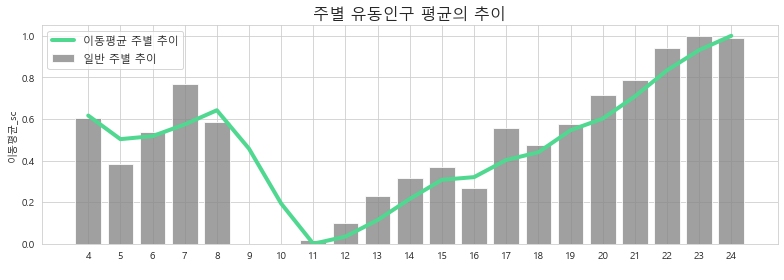

In [40]:
plt.figure(figsize=(11,4))
sns.lineplot(x='주', y='이동평균_sc', color=pal[0], data=fpopl_1, linewidth=4, label='이동평균 주별 추이')
plt.bar(x='주',height='인구수_sc', data=fpopl_1, color=pal[2], alpha=0.8, label='일반 주별 추이')
plt.xticks(list(range(4,25))); plt.legend(fontsize=11); plt.xlabel(' ')
plt.title('주별 유동인구 평균의 추이',fontsize=16)
plt.tight_layout()

### PCA를 통해 유동인구가 판매건수를 설명하는 정도를 확인

업종의 판매건수에서 PCA를 시행하여 PCA와 유동인구간의 상관관계를 살펴보았습니다.

In [41]:
card_new_pivot = pd.pivot(card_new[['업종','주','이동평균_건수']], index='주', columns='업종', values='이동평균_건수')
pca = PCA(n_components=10)
pca.fit(card_new_pivot)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [42]:
temp = pd.DataFrame(pca.transform(card_new_pivot))
temp['유동인구'] = fpopl_1['이동평균']
temp = temp.transform(lambda x: (x-x.min())/(x.max() - x.min()))

그 결과, 아래 플롯에서 확인할 수 있듯이, **업종들의 판매건수의 90%의 설명력을 차지하는 First, Second PCA Component가 각각 유동인구와 0.7, 0.6의 Correlation을 갖는 것**을 확인할 수 있었습니다. 즉, PCA에서 대부분의 설명력(분산)을 차지하는 두개의 변수가 유동인구와 높은 상관관계를 갖는다는 것은, 대부분의 판매건수 움직임이 사실상 유동인구를 따라간다는 것입니다.

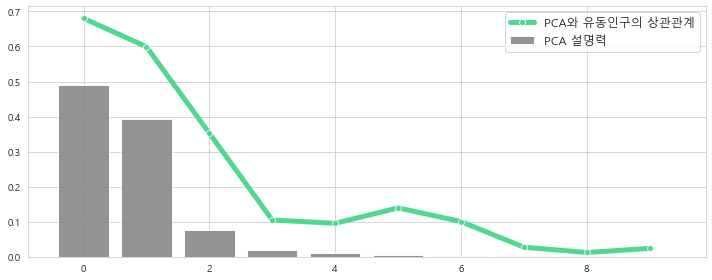

In [43]:
plt.figure(figsize=(10,4))
plt.bar(x = range(0,10), height=pca.explained_variance_/sum(pca.explained_variance_), label='PCA 설명력', color=pal[2], alpha=0.9)
sns.lineplot(x=range(0,10), y=abs(temp.corr()['유동인구'].drop('유동인구', axis=0)).values, marker='o', color=pal[0], linewidth=5, 
             label='PCA와 유동인구의 상관관계')
plt.legend(fontsize=12)
plt.tight_layout()

### 유동인구와 각 업종의 회복 기간 계산

각 업종의 판매건수가 유동인구와 깊은 관련이 있다는 것을 확인했습니다. 그 말인즉슨, 코로나로 인한 타격을 받은 업종이라면, 유동인구가 회복하는 기간동안 정도의 차이는 있지만 대체로 함께 회복했다는 것을 의미합니다. 그렇다면 이제, 유동인구가 회복하는 기간동안 위 클러스터에 등장하는 주요 업종들은 각각 얼만큼 회복했는지 확인해보겠습니다.

In [44]:
def recovery_versus_population(card_new_pivot, List, size=(5,5)):
    temp = card_new_pivot.T[card_new_pivot.columns.isin(List)].T.copy()
    temp['유동인구'] = np.array(fpopl_1['이동평균'])
    recover_point = []
    for i in range(0, len(temp.columns)):
    
        tt = temp[temp.index.isin([7,8])].mean(axis=0)[i] <= temp[temp.index > 11].iloc[:,i]
        recover_point.append(tt[tt == 1].index.min())
    
    recover_point = pd.Series(recover_point).fillna(24).tolist()
    recover_point = np.array(recover_point) - 12
   
    temp = temp.iloc[:,np.argsort(-recover_point)]
    recover_point = recover_point[np.argsort(-recover_point)]
    pop_recover_point = [10]*(len(List)+1)
    
    column = list(temp.columns)
    k = column.index("유동인구")
    colors = [pal[2]]*k + [pal[0]] + [pal[2]]*(len(column)-k)
    
    plt.figure(figsize=size)
    plt.title('대확산 이전으로의 회복 기간', fontsize=18)
    plt.barh(y=temp.columns,  width=recover_point, color=colors, alpha=0.8)
    plt.xlabel('소요 (이동평균) 주', fontsize=12)
    plt.yticks(fontsize=13) 
    plt.xticks(fontsize=13)
    plt.tight_layout()

**회복 기간 := 대확산 이전의 평범한 값(7,8주 평균, 설날과 대확산 기간의 영향을 안받는 주)에, 11주 이후에 도달하는데까지 소요된 기간**

아래 플롯을 보면, 대확산 이후 유동인구가 회복하기까지 걸린 기간은 9주입니다. 그런데, **(1)회복 기간이 거의 안 걸린 업종들, (2)유동인구보다 빠르게 회복된 업종들, (3)유동인구와 비슷하게 회복되고 있는 업종들, (4)해당 데이터에서는 판매건수를 회복하지 못한 업종들**이 존재하는 것을 볼 수 있습니다. 회복 기간이 0~1이라는 것은 애초에 타격을 딱히 받지 않았다는 것을 의미할 것이고, 회복 기간이 12주라는 것은 해당 데이터에 존재하는 기간 동안은 아직도 대확산 이전의 판매건수를 회복하지 못했다는 것을 의미합니다.

(2), (3)의 경우 유독인구의 회복 움직임과 관련이 더욱 있어보이고, 그에 반해 (1),(4)의 경우는 서로 다른 의미로 유동인구의 회복 움직임과 큰 관련이 없어보이는 회복 추세를 가지는 것 같습니다.

Text(10.8, 인터넷종합Mall, '(4)')

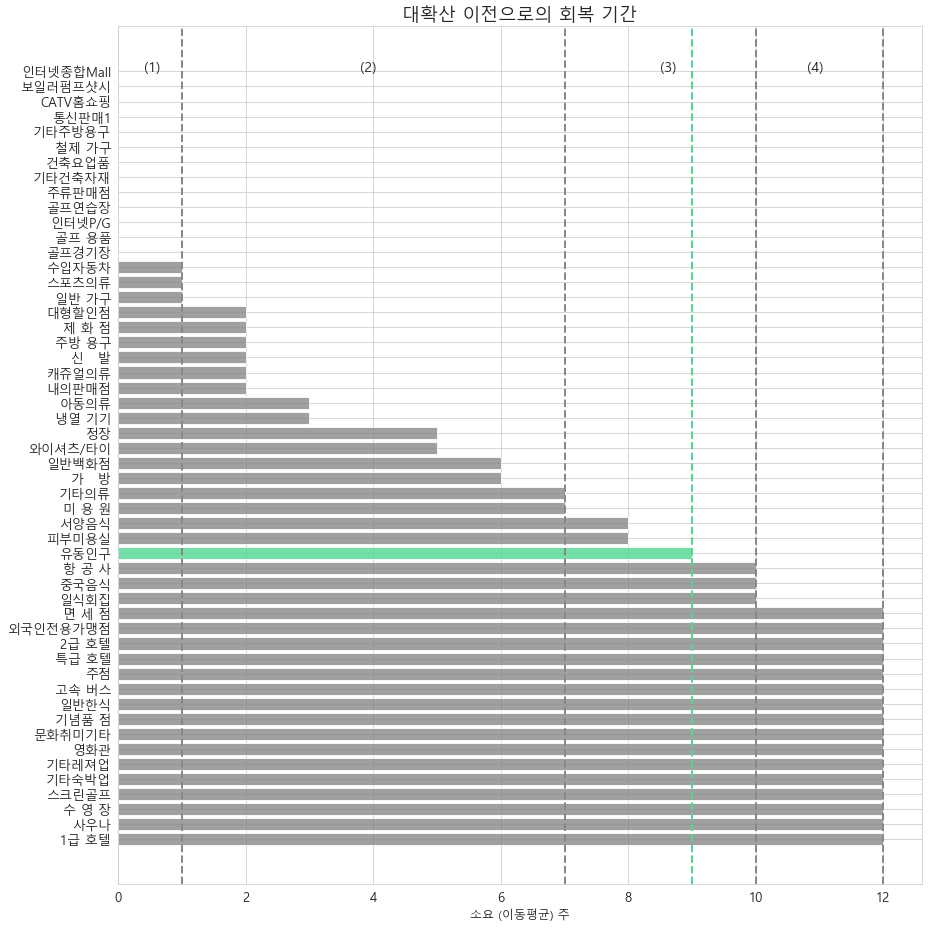

In [45]:
recovery_versus_population(card_new_pivot, ind1_1+ind1_2+ind2_1+ind2_2+ind2_3+ind3_1+ind3_2+ind3_3, size=(13,13))
plt.axvline(1, c=pal[2],linestyle='--',linewidth=2)
plt.axvline(7, c=pal[2],linestyle='--',linewidth=2)
plt.axvline(9, c=pal[0],linestyle='--',linewidth=2)
plt.axvline(10, c=pal[2],linestyle='--',linewidth=2)
plt.axvline(12, c=pal[2],linestyle='--',linewidth=2)
plt.text(0.4,'인터넷종합Mall', '(1)', fontsize=14)
plt.text(3.8,'인터넷종합Mall', '(2)', fontsize=14)
plt.text(8.5,'인터넷종합Mall', '(3)', fontsize=14)
plt.text(10.8,'인터넷종합Mall', '(4)', fontsize=14)

대체적으로 비슷한 업종들끼리 회복 기간도 비슷합니다. 물론, 같은 클러스터에 해당하는 업종이지만, 회복기간이 차이가 있는 업종들 또한 존재합니다. 하지만, 위의 회복 기간 계산 과정에서 7,8주의 평균이 그렇게 긴 기간이 아니기 때문에, 대확산 이전의 일반화된 값이 아닐 수 있다는 한계가 있습니다. 때문에, 위의 회복기간에 대해서는, 하나의 튀는 업종을 가지고 논의를 하기보다는, 주로 비슷한 업종들이 많이 포진된 회복 기간을 참고할 것입니다.

앞으로는, **판매건수의 클러스터 결과와 유동인구와의 회복추세 비교를 모두 참고하여 논의를 진행하고자 합니다.** 판매건수가 유동인구와의 회복 기간이 대체로 비슷한 (2), (3)에 대해서 먼저 살펴보고, 그 뒤 유동인구와의 회복 추세를 따르지 않는 (1),(4)에 대해 살펴보겠습니다.

1.보복성 소비: 주요 소비의 증가는 지속될 수 있을까 - **증가형태1, 회복기간(2)**  
2.소수에게만 해당되는 '배달'이라는 돌파구 - **굴곡형태2, 회복기간(3)**  
3.소비의 양극화 - **증가형태2,4, 회복기간(1)**  
4.희비가 교차하는 온라인 산업과 오프라인 산업  
&nbsp;&nbsp;&nbsp;  4.1.대확산 시기, 홀로 우뚝 선 비대면 상거래 업종 - **증가형태3, 회복기간(1)**    
&nbsp;&nbsp;&nbsp;  4.2.회복이 더딘 대표 오프라인 산업들 - **굴곡형태3,감소형태1, 회복기간(4)**    




---

# INSIGHT

---

# 1. 보복성 소비: 주요 소비의 증가는 지속될 수 있을까?

먼저 **증가형태1에 해당하는 업종들이자, 대체로 회복 기간이 (2)에 해당하는 업종들**에 대해서 살펴보았습니다. 타격 정도보다도 회복 정도가 훨씬 빠르게 증가하는 특징이 있는 업종들입니다.

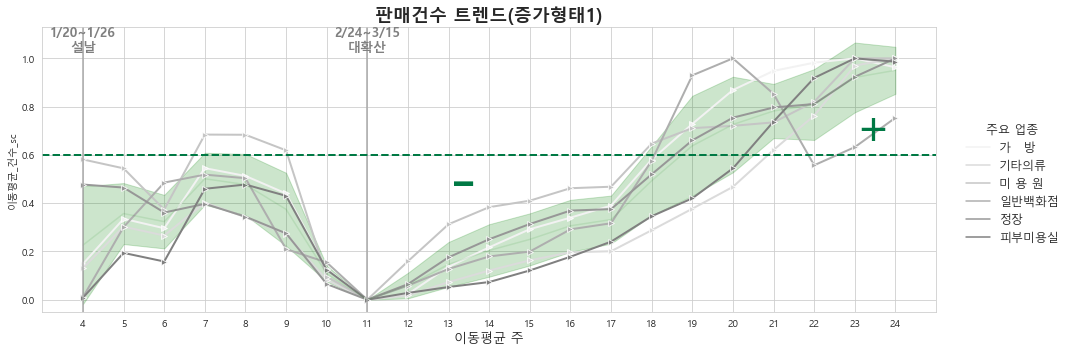

In [46]:
plot_trend(ind1_1, title='증가형태1')
plt.axhline(0.6, linewidth=2, linestyle='--', c=pal[1])
plt.text(13, 0.4, '-',fontdict={'color':pal[1],'size':70})
plt.text(23, 0.65, '+',fontdict={'color':pal[1],'size':50})
plt.tight_layout()

위 플롯을 보면, 11주 이전의 최대치보다도 11주 이후 판매건수가 더욱 증가하고 있는 것을 볼 수 있었습니다. 특히 코로나 대확산 기간동안 판매가 감소했던 부분(-)이 18주 이후로는 판매건수가 코로나 이전보다 회복되어(+), 마치 구멍났던 부분이 채워지는 것처럼 보입니다. 이에 해당하는 주요 업종들에는 ``가방, 기타 의류, 일반 백화점, 정장, 미용원, 피부 미용실``이 있습니다. 한편, 위 업종들과 매우 깊은 관련이 있는 또 다른 업종들은, 이보다도 훨씬 더 판매건수가 증가하는 패턴을 보였습니다.

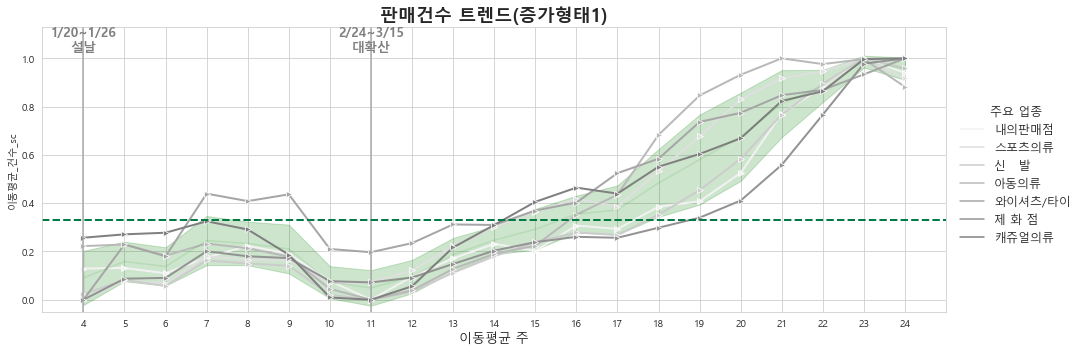

In [47]:
plot_trend(ind1_2, title='증가형태1')
plt.axhline(0.33, linewidth=2, linestyle='--', c=pal[1])

``내의 판매점, 스포츠 의류, 아동 의류, 캐쥬얼 의류, 와이셔츠/타이, 제화점, 신발`` 등 마찬가지로 패션 부문에 해당하는 업종들의 판매건수가 코로나 이전 최대치보다 훨씬 더 증가했습니다. 11주 이전 최대 판매건수가 3이라면, 24주의 최대 판매건수는 10이 되었습니다.


확실히, 위 업종들의 트렌드 플롯과 유동인구의 추이가 매우 흡사합니다. 분석 파트 2에서 했던 PCA Component1과도 11주 이전은 조금의 차이가 있지만 비슷한 추이를 갖습니다.

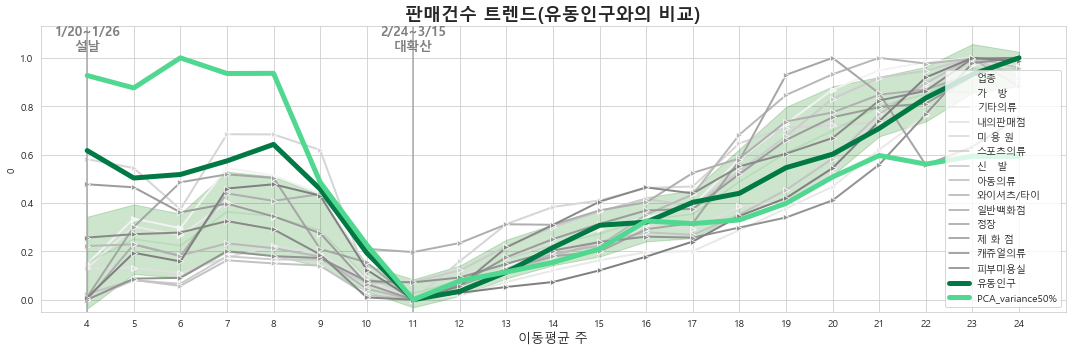

In [48]:
Week = fpopl_1['주']
plot_trend(ind1_1+ind1_2, title='유동인구와의 비교', legend=False)
sns.lineplot(x='주', y='이동평균_sc', color=pal[1], data=fpopl_1, linewidth=5, label='유동인구')
sns.lineplot(x=Week, y=temp[0], color=pal[0], linewidth=5, label='PCA_variance50%')
plt.xlabel('이동평균 주')
plt.tight_layout()

### 증가 추세가 이어질까? 아니면 빈 부분이 그저 채워진 것일까?

코로나 대확산 기간 동안 평균에 못 미쳤던 소비가 가장 빠르게 채워진 업종이 **의류, 신발, 가방 및 미용**이라는 것이 참 의외입니다. 포스트 코로나 시대와 같이 경제적 불황기, 소비 침체기에 이러한 사치적인 품목이 이렇게 유동인구보다도 빠른 회복력을 보인다는 것이 납득이 잘 되지 않았는데요. 그런데, 이러한 소비 현상을 설명하듯이, [조선비즈 기사](https://biz.chosun.com/site/data/html_dir/2020/06/13/2020061301392.html?utm_source=naver&utm_medium=original&utm_campaign=biz)에 따르면, 중국 광저우에 위치한 한 명품매장이 코로나19로 인해 문을 닫은 지 약 2달 이후 영업을 재개한 첫 날에 한화로 33억 매출, 하루 신기록을 세웠다고 합니다. 코로나19로 인해 소비하지 못했던 그 동안의 시절을 보상하다시피 명품 가방을 구매했다는 것입니다. 일종의 보상심리로 소비를 늘리는 것, 이를 바로 **보복성 소비**라고 합니다. 따라서 해당 업종들의 판매건수가 가장 빠르게 증가한 것은, **심리적인 요인이 크게 작용한 소비 현상**으로 판단됩니다.

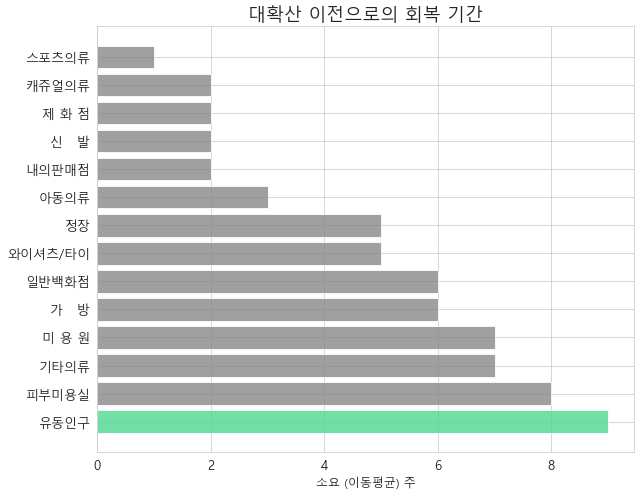

In [49]:
recovery_versus_population(card_new_pivot, ind1_1+ind1_2, size=(9,7))

다만, 이 소비의 증가가 정말 보복적 심리에서 발현된 것이라면, 이 소비의 증가는 굉장히 **일시적인 현상**일 것입니다. [중앙일보 기사](https://news.joins.com/article/23771761)에서, _'보복성 소비는 침체한 경제를 회복시키는 마중물이 되기도 한다. ... 나정환 DS투자증권 연구원은 " 코로나 19 확산 기간에 평균에 못 미치는 소비를 했기 때문에 코로나 19 종식 이후 평균 이상의 소비가 발생할 수 있으나 이는 일시적인 것"이라고 말한다.'_ 라고 합니다. 

더불어, 불안정한 포스트 코로나 시대에서 유동인구가 다시 급변할 가능성도 배제할 수 없습니다. 패션 및 미용 업종은 보복성 소비가 정말 일시적으로 끝나게 되어 증가 추세가 한풀 꺾인다면 어떻게 다시 매출을 증가시킬 지, 또는 코로나가 장기화된 불확실한 사회에서 어떻게 안정적으로 적정 이상의 매출을 유지할지 방안을 고찰해야 합니다. 

---

# 2. 소수에게만 해당되는 '배달'이라는 돌파구

아래 트렌드 플롯은 굴곡형태2에 해당하는 플롯입니다. 이 트렌드에 해당하는 업종들에는 ``일반한식, 일식회집, 중국음식, 서양음식, 주점``등의 음식과 관련된 업종들이 많았습니다. 

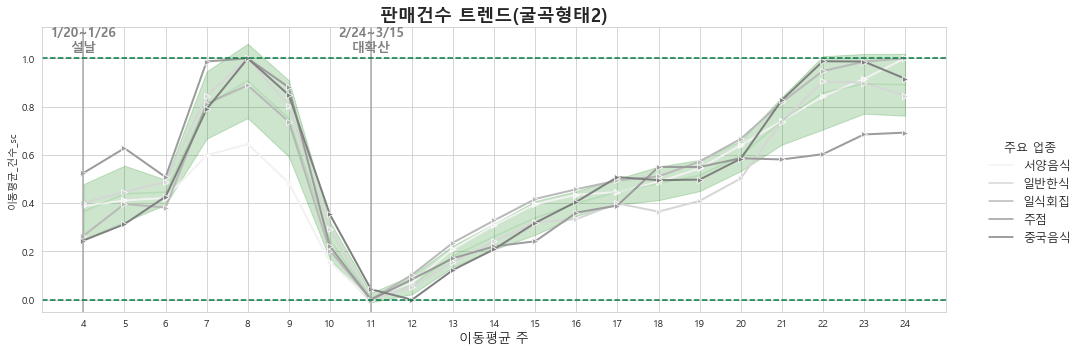

In [50]:
plot_trend(ind2_1, title='굴곡형태2')
plt.axhline(1, linestyle='--', linewidth=1.5, c=pal[1])
plt.axhline(0, linestyle='--', linewidth=1.5, c=pal[1])

카드 데이터의 외식업종 판매건수는 대체로 배달을 포함하지 않는 건수라고 판단했습니다. 확실히, 대확산 시기에 외식업종 오프라인 판매건수는 큰 타격을 입은 것으로 보입니다. 회복 기간은 대체로 (3)에 해당하는 업종들로, 유동인구와의 회복 속도가 상당히 비슷합니다. 오프라인 매출 건수이다 보니 유동인구와 회복속도가 매우 비슷한 것이 납득 가는 부분입니다.

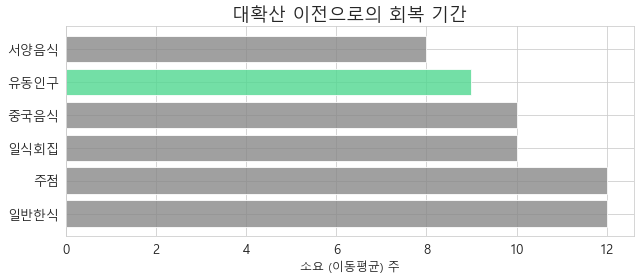

In [51]:
recovery_versus_population(card_new_pivot, ind2_1, size=(9,4))

그런데, 외식업종의 경우 특히 배달이 잘 되어 있다는 것이 특징입니다. 따라서, 오프라인 판매건수만 확인할 것이 아니라, 배달 건수의 전반적인 추이를 확인해보았습니다.


In [52]:
delivery = delivery[delivery['DLVR_STORE_SIDO']=='서울특별시'] #서울특별시에 위치한 상점만
delivery = delivery[delivery['DLVR_REQUST_STTUS_VALUE']==1].reset_index(drop=True) #배달 완료한 것만

delivery_1 = delivery[['PROCESS_DT', 'SERIAL_NUMBER']].groupby('PROCESS_DT').count().reset_index().copy() #일별 배달건수
delivery_1['주'] = pd.to_datetime(delivery_1['PROCESS_DT']).dt.week
delivery_1 = delivery_1.groupby('주').mean().reset_index() #주별 평균
delivery_1 = delivery_1[~delivery_1['주'].isin([1,2,3,25])].reset_index(drop=True)
delivery_1['이동평균'] = round(delivery_1['SERIAL_NUMBER'].rolling(window=3, min_periods=1).mean()) #배달 건수의 이동평균
delivery_1['이동평균_sc'] = delivery_1['이동평균'].transform(lambda x:(x-x.min())/(x.max()-x.min()))

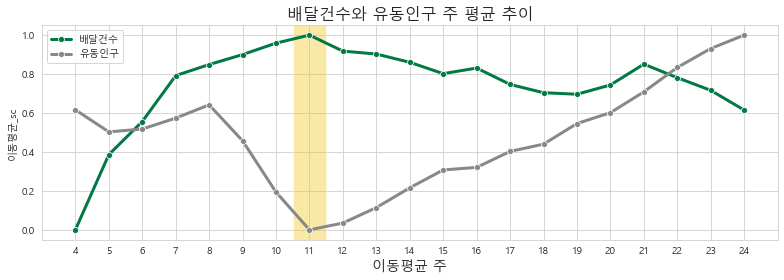

In [53]:
plt.figure(figsize=(11,4))
sns.lineplot(x='주', y='이동평균_sc', color=pal[1], data=delivery_1, linewidth=3, marker='o', label='배달건수')
sns.lineplot(x='주', y='이동평균_sc', color=pal[2], data=fpopl_1, linewidth=3, marker='o', label='유동인구')
plt.xticks(list(range(4,25))); plt.legend(); plt.xlabel('이동평균 주',fontsize=14)
plt.axvspan(10.5, 11.5, facecolor=pal[3], alpha=0.4)
plt.title('배달건수와 유동인구 주 평균 추이',fontsize=16)
plt.tight_layout()

위 플롯을 보면, 예상대로 11주에 배달 건수가 정점이었고, 유동인구는 최저를 찍었습니다. 그런데 11주 이후 유동인구는 비교적 가파르게 상승하는 것에 비해, 배달건수의 감소 추세는 상당히 완만합니다. **사람들이 다시 외부활동을 점점 시작했음에도 배달은 적게 감소하고 있는 형태인데요.** 기울기의 차이를 더욱 확실히 보기 위해, 11주 이후의 외식업의 카드 판매건수, 배달 건수, 유동인구의 추세를 비교해보았습니다.

### 배달을 포함한 외식업의 회복력

In [54]:
def get_recover_power(Data, 업종_True_or_False, 업종):   
    if 업종:
        diff = []
        for kind in 업종:
            before = Data[(Data['업종'] == kind) & (Data['주'].isin([7, 8]))].mean()['이동평균_건수_sc']
            post = Data[(Data['업종'] == kind) & (Data['주'] > 11)]['이동평균_건수_sc']
            diff.append(np.array(post - before))
            
        diff = np.array(pd.DataFrame(diff).mean(axis=0))
    else:
        before = Data[Data['주'].isin([7,8])]['이동평균_sc'].mean()
        post = np.array(Data[Data['주'] > 11]['이동평균_sc'])
        diff = post - before
    
    return diff

In [55]:
diff_pop = get_recover_power(fpopl_1, False, None)
diff_del = get_recover_power(delivery_1, False, None)
diff_upj = get_recover_power(card_new, True, ind2_1)

week = [i for i in range(12, 25)]    
for_deriv_upj = pd.DataFrame({'회복력':diff_upj - min(diff_upj), '주':week, 'hue':['외식']*13})
for_deriv_pop = pd.DataFrame({'회복력':diff_pop - min(diff_pop), '주':week, 'hue':['유동']*13})
for_deriv_del = pd.DataFrame({'회복력':diff_del, '주':week, 'hue':['배달']*13})

In [56]:
recover1 = for_deriv_upj.append(for_deriv_pop)
recover1 = recover1.append(for_deriv_del)

아래 플롯을 보면, 11주 이후 추세가 비슷하기는 하지만, 유동인구보다 외식업의 판매건수가 조금 더 느리게 회복되고 있는 것을 확인할 수 있습니다. 그렇다면, 배달 건수와 판매건수의 추세를 합쳐보겠습니다.

Text(0.5, 1, '대확산 이후 회복 추세')

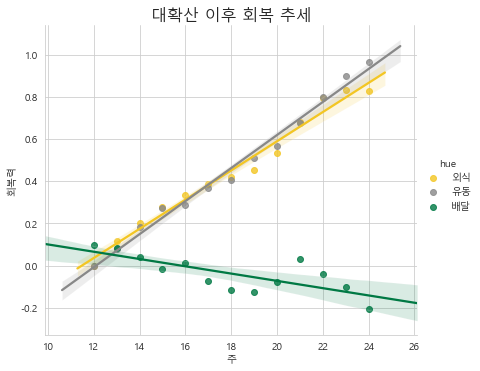

In [57]:
color_dict = dict({'외식':pal[3], '배달':pal[1], '유동': pal[2]})
sns.lmplot(x='주', y='회복력', data=recover1,aspect=1.2, height=5, order=1, hue='hue', palette=color_dict)
plt.title('대확산 이후 회복 추세', fontsize=16)

In [58]:
Sum = for_deriv_upj['회복력'] - for_deriv_del['회복력']
recover2 = for_deriv_upj.copy()
recover2['회복력'] = Sum + 0.1; recover2['hue'] = ['외식 + 배달']*13
recover2 = recover2.append(for_deriv_pop)

그 결과, 아래 플롯과 같이 확실히 외식업+배달의 추세가 유동인구보다 더 가파르게 회복하는 추세를 보입니다.

Text(0.5, 1, '대확산 이후 회복 추세')

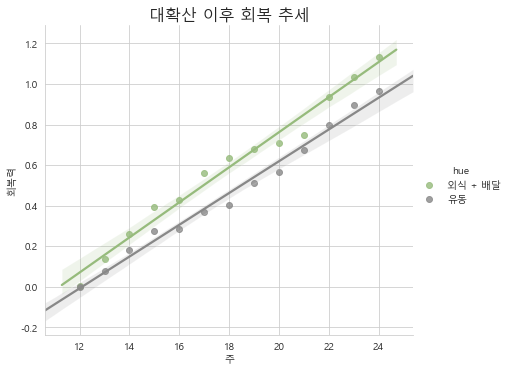

In [59]:
color_dict = dict({'외식 + 배달':pal[5], '유동': pal[2]})
sns.lmplot(x='주', y='회복력', data=recover2, aspect=1.2, height=5, order=1, hue='hue', palette=color_dict)
plt.title('대확산 이후 회복 추세', fontsize=16)

음식점은 배달을 포함하면 대확산 시기 이후, 유동인구의 회복 추세보다 더 빨라지는 것으로 판단됩니다. 유동인구가 증가하는 속도에 비해, 배달건수가 감소하는 속도가 작다는 것이 주목할 만 합니다. 이에 따라, 외식업종에서 배달 산업은 큰 돌파구로 보이지만, 문제는 바로 **가게 별 배달건수가 굉장히 불균형하다**는 것입니다!

### 배달 건수의 불균형

저는 배달 데이터에서 서울특별시에 위치한 배달 상점과, 배달이 완료된 건만 확인했습니다. 이 때, 배달 상점의 개수는 804개이고, 1월 1일부터 6월 21일까지 전체 배달 건수는 779456입니다. 이 때, 가장 배달 건수가 많은 순서대로 배달 상점을 나열하여, 804개의 상점 중 상위 10%(약 80개)에 해당하는 배달 상점과, 상위 25%(약 201개)에 해당하는 배달 상점들이, 각각 전체 배달 건수에서 차지하는 비중을 확인했습니다.

In [60]:
delivery_2 = delivery[['SERIAL_NUMBER', 'PROCESS_DT', 'DLVR_STORE_ID', 'DLVR_STORE_INDUTY_NM']].copy()
print('2020년 1월1일~6월21일 동안 전체 배달건수: ', delivery_2.shape[0])
print('배달 상점 개수:', delivery_2['DLVR_STORE_ID'].nunique())

2020년 1월1일~6월21일 동안 전체 배달건수:  779456
배달 상점 개수: 804


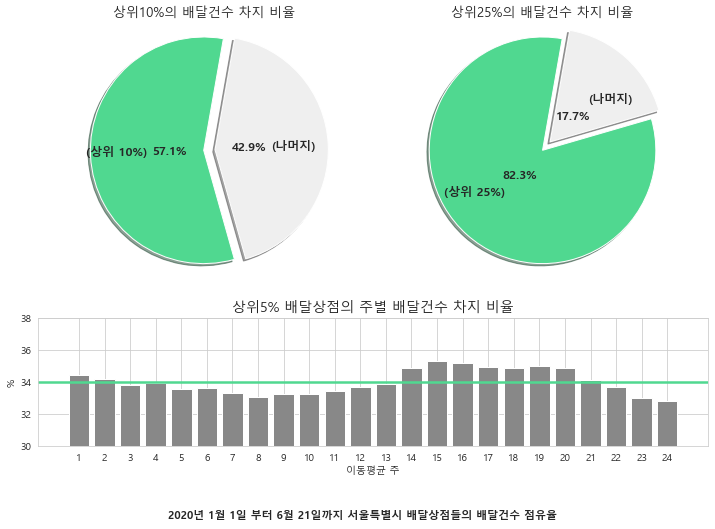

In [61]:
delivery_2['주'] = pd.to_datetime(delivery_2['PROCESS_DT']).dt.week #주(week) 변수 생성
store_num = []
delivery_market = []
for i in list(range(1,25)):
    temp = delivery_2[delivery_2['주']==i] #각 주에서
    num = round(temp['DLVR_STORE_ID'].nunique()*5/100) #상위 5%의 배달건수를 차지하는 상점의 개수
    store_num.append(temp['DLVR_STORE_ID'].nunique()) 
    delivery_market.append(temp['DLVR_STORE_ID'].value_counts().head(num).sum()/temp.shape[0]*100) 
    
percent_top5 = list(pd.DataFrame(delivery_market).rolling(window=3, min_periods=1).mean()[0])

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12, 8)) 
gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[:2, :2]) 
ax2 = fig.add_subplot(gs[:2, 2:]) 
ax3 = fig.add_subplot(gs[2:, :])

percent = [10,25] # 5%와 25%의 배달 비중 볼 것.
delivery_2['배달 시장 비중'] = ['(나머지)']*delivery_2.shape[0]

for num,p in enumerate(percent):
    ax = ax1 if num==0 else ax2
    i = round(delivery_2['DLVR_STORE_ID'].nunique()*p/100)
    store = delivery_2['DLVR_STORE_ID'].value_counts().head(i).index
    ind = delivery_2[delivery_2['DLVR_STORE_ID'].isin(store)].index
    delivery_2.loc[ind,'배달 시장 비중'] = delivery_2.loc[ind,'배달 시장 비중'].apply(lambda x: '(상위 '+str(p)+'%)')
    delivery_2['배달 시장 비중'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True, startangle=80,
                                             labels=delivery_2['배달 시장 비중'].value_counts().index, colors=[pal[0], pal[4]],
                                             textprops={'weight':'bold', 'fontsize':12},labeldistance=0.5, pctdistance=0.3, ax=ax)
    ax.axis('off')
    ax.set_title('상위'+str(p)+'%의 배달건수 차지 비율', fontsize=13, position=(0.5, 0.95))

x = list(range(1,25))    
ax3.bar(x, percent_top5, color=pal[2])
ax3.set_ylim(30,38); ax3.set_xticks(x)
ax3.axhline(34, color=pal[0], linewidth=2.5)
ax3.set_title('상위5% 배달상점의 주별 배달건수 차지 비율', fontsize=14)
ax3.set_ylabel('%'); ax3.set_xlabel('이동평균 주')
fig.suptitle('2020년 1월 1일 부터 6월 21일까지 서울특별시 배달상점들의 배달건수 점유율', weight='bold', fontsize=11, position=(.5, 0.09))
plt.subplots_adjust(top = 0.96, wspace=0.05, bottom=0.2)

위의 파이 플롯을 보면, 전체 804개의 상점 중 상위 10%가 전체 배달 건수의 57%를 차지하고 있었고, 상위 25%는 약 82%를 차지하고 있었습니다. 즉, 하위 600여개의 상점이 나머지 18%의 배달 건수를 차지하고 있는 것입니다! 한편, 위 플롯에서 막대 플롯은, 주별 상위 5%에 해당하는 가게의 배달 건수 비중입니다. 평균적으로는 약 34%이고, 33%에서 35%까지 올라갔다 내려갔다하는 모습을 볼 수 있습니다. 1월부터 6월까지의 기간이 매우 짧기 때문에, 코로나로 인한 비중의 변화가 존재한다고 판단하기는 이른 것 같습니다. 그렇지만, 매주 상위 5%의 가게가 전체 판매 건수의 약 1/3을 차지한다는 것은 알 수 있었는데요. **애초에 배달 건수가 이렇게 불균형하기 때문에 배달이 돌파구 역할을 하는 음식점은 소수에 해당된다고 볼 수 있을 것 같습니다.**

### 배달 건수가 왜 이렇게 불균형할까?

생각해 보면, 배달을 시킬 때에는 어떤 걸 시킬지 미리 정하고 시키거나, 탐색을 한다 해도 리뷰가 많거나 잘 알려진 프랜차이즈 음식을 주문하는 경우가 많습니다. 즉, 배달 음식의 경우, 정보가 많고 신뢰할 수 있는 음식을 선호합니다. 그런데, 학교를 다니거나 어딘가에 매일 출퇴근할 때에는, 그 근처에 있는 다양한 음식점을 방문할 가능성이 많아집니다. 예를 들어, 저의 학교 주변 상권은 저의 학교 학생들이 가장 큰 비중을 차지하는데요. 평상시 학기 중 점심시간이나 저녁시간에는 많은 음식점들이 학생들로 꽉 차고, 가려던 곳에 이미 자리가 없다면 다른 곳으로 발길을 돌립니다. **어떤 컵에 물이 넘치면 다른 컵으로 그 넘치는 물을 받는 그림입니다.** 그런데 이번 학기 사이버 강의로 진행되면서, 학교와 주변 상권이 텅 비게 되었고, 한 컵에서 넘치는 물을 받는 다른 컵의 그림은 온데간데 없습니다. **사실상 전체적으로는 유동인구의 회복추세보다 빠르게 회복하지만, 대부분의 음식점들은 훨씬 느리게 회복하는 것으로 판단됩니다.**

배달 건수의 감소 추세를 볼 때, 코로나가 잠잠해지더라도 배달 이용 건수가 대폭 감소할 것으로 보이지 않습니다. 상대적으로 인지도가 낮은 음식점들은, **소비자들의 정보 부족으로 인한 우려를 달래고** 배달 시장에서 존재감을 어떻게 높일 수 있을지, 어떻게 가진 자본 하에서 효과적으로 홍보할 수 있을지에 대한 고찰이 필요합니다.

---

# 3. 소비의 양극화

이번에는 코로나에 의해 큰 타격을 받지 않는 것처럼 보이는 클러스터들에 대해 살펴보겠습니다. 먼저 아래 트렌드는 증가형태4에 해당하는 것입니다. 설날의 영향이 없어지는 이동평균 주 7주차(1/27~2/16 평균) 이후로 판매건수가 회복되어 그 뒤로도 판매건수를 얼추 유지하고 있는 모습을 보입니다. 물론 11주 근처에 약간의 떨어짐이 있는 업종들도 있지만, 이 정도면 다른 업종들에 비해 판매건수를 충분히 유지하고 있다고 볼 수 있습니다.

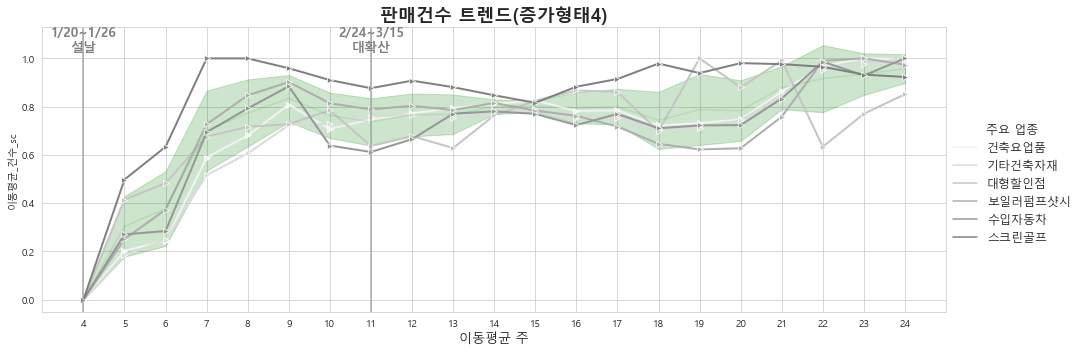

In [62]:
plot_trend(ind2_2, title='증가형태4')

주요 업종들은 크게 그 성격에 따라, 엄밀하지는 않지만 이렇게 둘로 나눌 수 있을 것 같습니다.
-	**필수적인 느낌**: 건축요업품, 기타건축자재, 보일러펌프샷시, 대형할인점 
-	**사치적인 느낌**: 수입자동차, 스크린골프

건축요업품, 기타건축자재 등의 업종은 일반 사람들에게 필수재는 아니지만, 그래도 필요해서 소비하는 업종에 더 가깝기 때문에 이렇게 분류해보았습니다.

한편, 두번째 클러스터는 증가형태2에 해당하는 것으로, 다음과 같습니다.

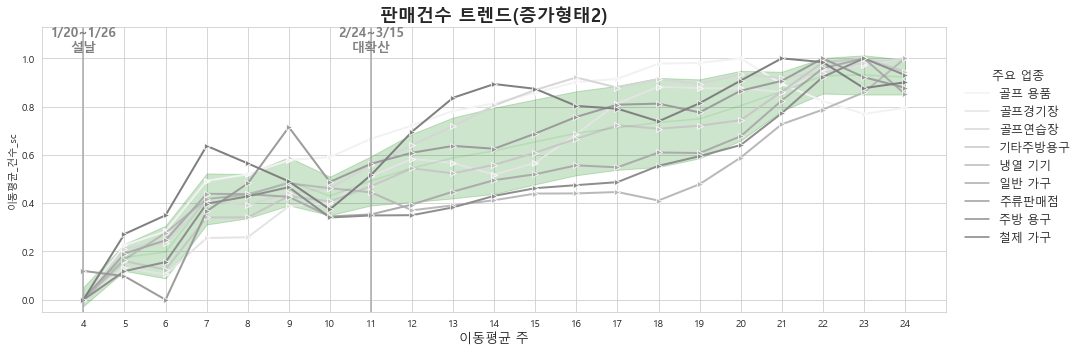

In [63]:
plot_trend(ind2_3, title='증가형태2')

두번째 클러스터는 시간이 지날수록 선형적으로 판매건수가 상승하는 패턴을 보이고 있습니다. 두번째 클러스터에 해당하는 주요 업종은 이렇게 나눌 수 있을 것 같습니다
- **골프**: 골프 용품, 골프경기장, 골프연습장
- **집에 대한 소품**: 기타주방용구, 냉열기기, 일반가구, 주방용구, 철제 가구

회복기간은 다음과 같습니다. 아예 회복기간이 걸리지 않거나 얼마 걸리지 않는 업종들이 대부분인데요. 스크린 골프는 회복 기간이 12주라고는 하지만, 위의 트렌드 플롯을 참고할 때, 정말 큰 타격을 입어서 회복이 안 되고 있는 케이스가 아니라, 회복 기간 산출의 한계에 해당하는 케이스로 볼 수 있을 것 같습니다. (대확산 이전의 값을 가까이 유지하고는 있으나, 정확한 그 값이 나오지 않아서 회복 기간이 크게 나왔습니다.)

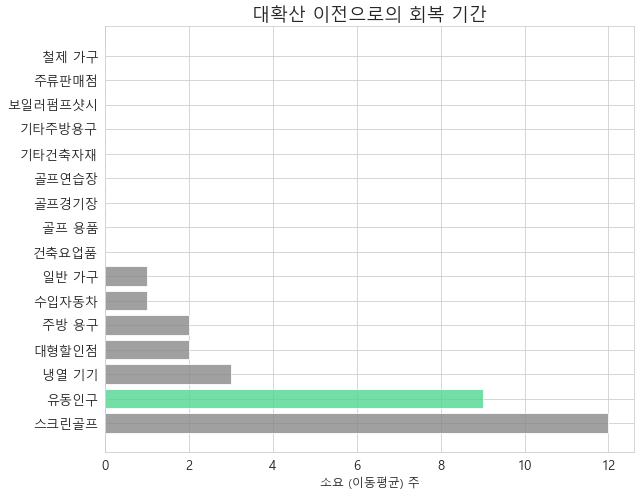

In [64]:
recovery_versus_population(card_new_pivot, ind2_2+ind2_3, size=(9,7))

그런데 이 두 클러스터에 해당하는 업종들은 각각의 특성이 참 다양하다는 것이 특징입니다. 사치적인 품목 관련 업종부터, 생필품 관련 업종까지 존재하는데요. 그렇다면, 판매금액과 함께 이 업종들의 소비 패턴의 특성을 알아보겠습니다.

### [가심비 소비] “가격을 올려도 내가 좋아하는 건 산다” (수요↑, 지불용의↑)

가장 먼저 보이는 이 두 클러스터 업종의 공통점은 바로 **골프**입니다. 첫번째 플롯에는 ``스크린골프장``, 두번째 플롯에는 ``골프 용품, 골프경기장, 골프 연습장``이 포함되어 있는데요. [조선 비즈 기사](https://biz.chosun.com/site/data/html_dir/2020/06/30/2020063000574.html)에 따르면, 실제로 코로나 사태 이후 골프 관련 산업이 호황을 누리고 있다고 합니다. 수요가 늘어서 많은 골프장이 가격을 올렸고, 이에 대한 불만을 토로하는 글이 올라오고 있음에도, “가격을 올려도 가겠다는 사람은 줄을 설 것”이라는 반응이 나오고 있다고 하는데요. 아무리 코로나로 인해 소비심리가 위축되었다고 해도, 고급 스포츠에 해당하는 골프에 대한 소비는 오히려 증가하는 것을 볼 수 있습니다. 첫번째 플롯에서 ``수입자동차`` 역시 같은 맥락이라 볼 수 있을 것 같습니다. 

이 업종들에 대해, 주별 이동평균 판매금액을 이동평균 판매건수로 나눠서, **한 건당 (이동평균) 판매금액**이 전반적으로 어떻게 변화했는지 확인했습니다. 주별 건당 판매금액이 결국 그 주의 사람들의 해당 업종에 대한 **지불용의**를 의미한다고 생각했기 때문입니다.

In [65]:
card['건당 이동평균_금액'] = card['이동평균_금액']/card['이동평균_건수'] #주별 한 건당 판매금액 변수 생성 
card = card.fillna(0) #Null값 뜨면 0으로 대체. (판매건수가 0이라는 뜻이므로)

#Scaling
card['건당 이동평균_금액_sc'] = np.zeros(card.shape[0])
for kind in card['업종'].unique():
    temp = card[card['업종'] == kind].copy()
    temp['건당 이동평균_금액_sc']  = temp['건당 이동평균_금액'].transform(lambda x:(x-x.min())/(x.max()-x.min()))
    index = temp.index
    card.loc[index,'건당 이동평균_금액_sc'] = temp['건당 이동평균_금액_sc']

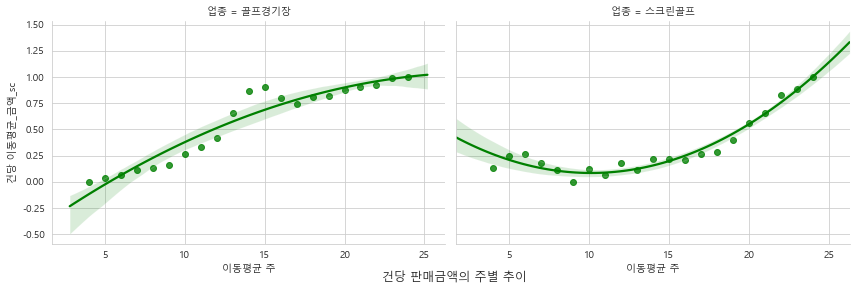

In [66]:
temp = card[card['업종'].isin(['골프경기장','스크린골프'])][['주','업종','건당 이동평균_금액_sc']].copy()
lm1=sns.lmplot(x='주', y='건당 이동평균_금액_sc', col='업종',scatter_kws={'color':'green'},line_kws={'color':'green'}, data=temp, 
               aspect=1.5, height=4, order=2)
lm1.set_xlabels('이동평균 주')
plt.suptitle('건당 판매금액의 주별 추이',fontsize=12, position=(.53, 0.04))
plt.tight_layout()

실제로 위 플롯을 보면, ``골프경기장``과 ``스크린골프``는 시간이 지날수록 건당 판매금액이 올라가고 있습니다! 가격이 올라가고 있음에도 수요가 올라간 것이 사실인 것 같습니다. 한편, ``골프 용품``과 ``수입자동차``의 경우 추이가 비선형적인 편이지만, 사람들의 지불 용의가 딱히 감소하지 않은 업종에 해당한다고 볼 수 있을 것 같습니다. 

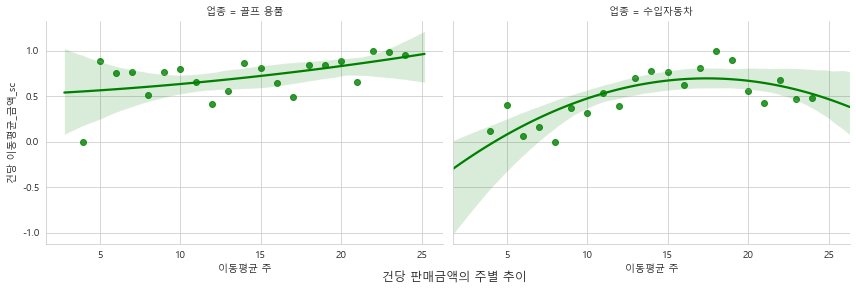

In [67]:
temp = card[card['업종'].isin(['골프 용품','수입자동차'])][['주','업종','건당 이동평균_금액_sc']].copy()
lm2=sns.lmplot(x='주', y='건당 이동평균_금액_sc', col='업종', data=temp, scatter_kws={'color':'green'}, line_kws={'color':'green'},
               aspect=1.5, height=4, order=2)
lm2.set_xlabels('이동평균 주')
plt.suptitle('건당 판매금액의 주별 추이',fontsize=12,  position=(.53, 0.04))
plt.tight_layout()

 **아무리 경기가 불황이고 가격도 점점 증가해도, 자신이 큰 가치를 두고 있는 것에 대해서는 소비를 줄이지 않는 것** 같습니다. 이를 가치 소비, 또는 가격 대비 심리적 만족도라는 의미에서 **가심비 소비**라고 부르는데요. 골프와 자동차 관련 업종에서 특히 가심비 소비 현상을 볼 수 있었습니다.

그런데, 위의 판매건수가 변함없이 높은 업종들 중에서 반대로 건당 판매금액은 감소하는 업종들이 있습니다.

### [가성비 소비] "필요한 건 최대한 싸게" or "싸니까 산다" (수요↑, 지불용의↓)

``일반 가구, 기타주방용구`` 등 집과 관련한 업종의 판매건수는 증가 추세였지만, 한 건당 판매금액은 감소하는 추세를 보였습니다! 즉, **수요는 증가했는데 지불용의는 감소했다는 것입니다.** 가격을 내렸더니 사람들이 많이 구매한 것, 또는 사람들이 싼 가격의 물건을 위주로 많이 구매한 것에 해당하는데요. 집에 있는 시간이 많아지면서 집에 대한 관심은 많아졌는데, 그렇다고 많은 돈을 쓰기에는 부담이 되서 가성비템을 찾게 된 것으로 보입니다. 또, 눈에 띄는 것이 바로 ``주류판매점``입니다. [그린포스트 기사](http://www.greenpostkorea.co.kr/news/articleView.html?idxno=117499)에 따르면, 가정용 주류 매출이 크게 증가했다고 합니다. 외부 술자리가 감소하고 대신 홈술(home-술)족이 증가하면서, 주류 업계는 홈술족을 위한 여러가지 프로모션들을 진행했다고 하는데요. 예를 들어, 가볍게 먹을 수 있도록 소용량으로 출시하면서, 소비자들은 "이거 하나 사서 집에서 먹어도 되겠다"며 가격 부담이 적어져 무계획적인 주류 소비가 증가한 것이 아닌가 싶습니다. 더불어, ``보일러펌프샷시`` 등 필요해서 소비를 해야하는 것은 더욱이 최대한 저렴하게 해결하고자 하는 것 같습니다.


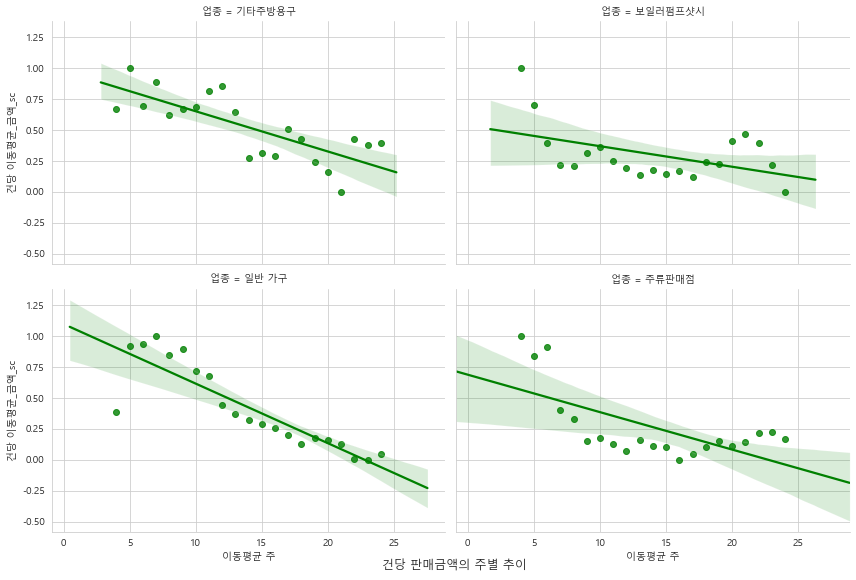

In [68]:
temp = card[card['업종'].isin(['일반 가구', '기타주방용구', '보일러펌프샷시', '주류판매점'])][['주','업종','건당 이동평균_금액_sc']].copy()
lm3=sns.lmplot(x='주', y='건당 이동평균_금액_sc', col='업종', col_wrap=2, data=temp, scatter_kws={'color':'green'},line_kws={'color':'green'},
               height=4, aspect=1.5)
lm3.set_xlabels('이동평균 주')
plt.suptitle('건당 판매금액의 주별 추이',fontsize=12, position=(.53, 0.02))
plt.tight_layout()

한편, ``농축수산품, 대형할인점, 슈퍼마켓, 인터넷 종합 Mall, 정육점``은 위 클러스터에는 존재하지 않았던 업종들이지만, 지불용의가 감소하는 추세인 업종들에 해당합니다. 20주 이후 살짝 상승하는 모습을 보이긴 하는데, 5월 이후 재난지원금의 영향으로 짐작됩니다. 대표적으로 사람들의 **생필품**과 관련이 큰 업종들인데요. ``보일러펌프샷시``와 같은 맥락으로, **"필요해서 사야하는 건 최대한 싸게 사자"** 는 심리때문이 아닌가 싶습니다. 

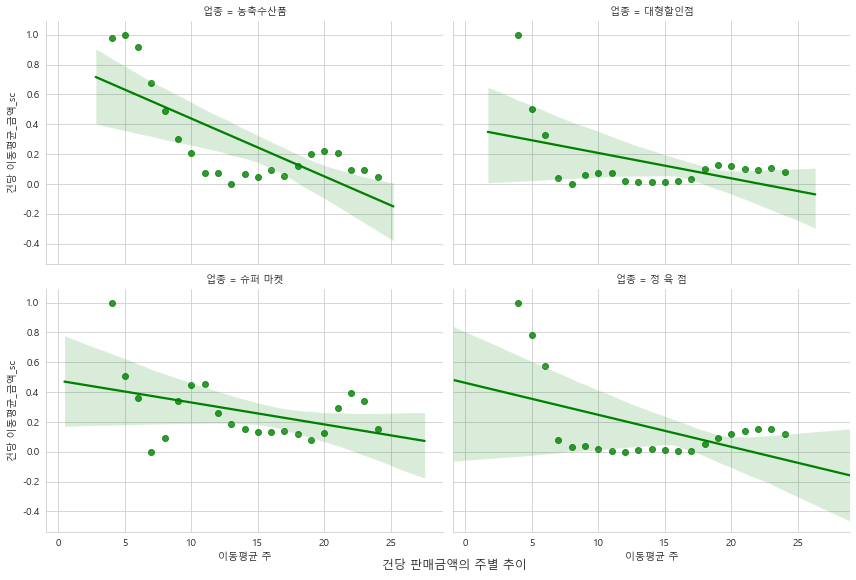

In [69]:
temp = card[card['업종'].isin(['농축수산품', '대형할인점', '슈퍼 마켓', '정 육 점'])][['주','업종','건당 이동평균_금액_sc']].copy()
lm4=sns.lmplot(x='주', y='건당 이동평균_금액_sc', col='업종', col_wrap=2 ,data=temp, aspect=1.5, height=4,
              scatter_kws={'color':'green'},line_kws={'color':'green'})
lm4.set_xlabels('이동평균 주')
plt.suptitle('건당 판매금액의 주별 추이',fontsize=12, position=(.53, 0.02))
plt.tight_layout()

정리하면, **가격보다는 자신에게 주는 가치, 심리적인 만족도가 중요한 재화**와 **쌀수록 많이 팔리는 박리다매형 재화**가 구분되는 것을 볼 수 있었습니다. 전자의 경우는 주로 취미, 사치품과 관련된 재화에 해당하고, 후자는 생필품이거나 싸니까 계획에 없던 소비가 일어나는 경우가 주로 해당되었습니다. 경기가 안좋으면 대부분 가격 부담이 적은 것을 위주로 소비할 것 같았는데, 자신에게 큰 만족도를 주는 것에 대해서는 지출을 아끼지 않는 것을 볼 때, 사람들이 포스트 코로나 시대에서도 구매 의사가 충분히 있는 것 같습니다. 무조건 아껴봤자 미래는 불확실하고, 펑펑 쓰기에도 역시나 미래가 걱정되면서, 나름 쓸 때와 안 쓸 때를 전략적으로 정해서 살아가는 것이 아닐까 싶습니다. 다만, 골고루 돈을 쓴다기보다, 자신의 자금을 **선택과 집중하는 형태**로 소비 형태가 자리잡은 것 같습니다. 따라서 각 업종은 이를 고려하여 자신의 컨셉 및 전략을 수립해야 합니다.

---

# 4. 희비교차가 엇갈리는 온라인 산업과 오프라인 산업

## 4.1. 대확산 시기, 홀로 우뚝 선 비대면 상거래 업종

모든 클러스터가 11주에는 크든 작든 타격을 입었는데, 한 클러스터만이 11주에 판매건수가 오히려 피크를 찍었습니다! 역시나 예상대로, ``인터넷종합Mall, 인터넷P/G, CATV홈쇼핑, 통신판매1`` 등 **비대면 상거래** 업종이었는데요. 

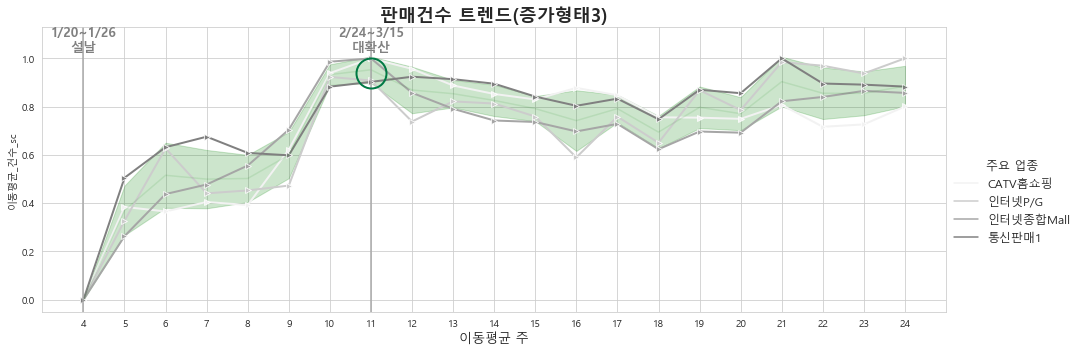

In [70]:
plot_trend(ind3_1, title='증가형태3')
plt.plot(11, 0.94, 'o', ms=30, mec=pal[1], mfc='none', mew=2)

타격을 입지 않았기에 회복 기간 또한 걸리지 않았습니다.

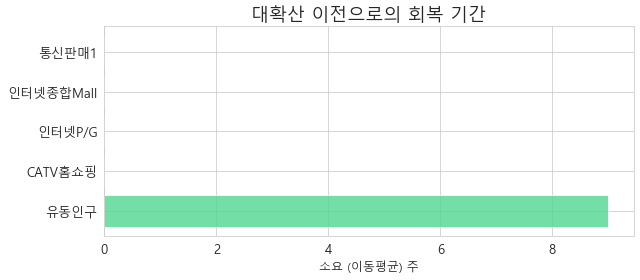

In [71]:
recovery_versus_population(card_new_pivot, ind3_1, size=(9,4))

그렇다면, 위 업종들이 전체 판매금액에서 몇 퍼센트를 차지하는지 확인해보았습니다. 

In [72]:
#판매금액 차지 비율 변수 (해당 주에 전체 판매금액 중 몇퍼센트 차지했는지)
card['판매금액 차지 비율'] = np.zeros(card.shape[0])
for i in range(4,25):
    temp = card[card['주']==i].copy() 
    summation = temp['판매금액'].sum() #i주차 판매금액 총 합
    temp['판매금액 차지 비율'] = temp['판매금액']/summation *100
    idx = temp.index
    card.loc[idx,'판매금액 차지 비율'] = temp['판매금액 차지 비율']

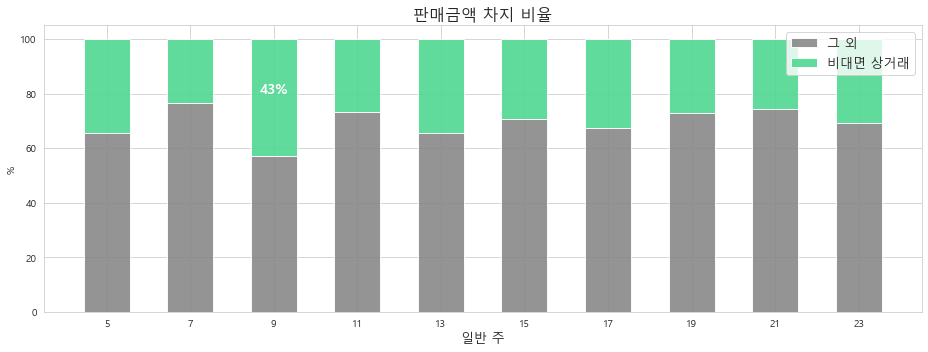

In [73]:
card['분류'] = ['그 외']*card.shape[0]
idx = card[card['업종'].isin(ind3_1)].index
card.loc[idx,'분류'] = card.loc[idx,'분류'].apply(lambda x: '비대면 상거래')
card3_1 = card.groupby(['주','분류']).sum().reset_index().copy()
card3_1 = card3_1[card3_1['주'].isin(list(range(5,25,2)))].reset_index(drop=True)

labels = range(5,25,2)
other = card3_1[card3_1['분류']=='그 외']['판매금액 차지 비율']
online = card3_1[card3_1['분류']=='비대면 상거래']['판매금액 차지 비율']
width = 1.1

fig, ax = plt.subplots(1,1, figsize=(13,5))
ax.bar(labels, other, width, label='그 외',color=pal[2], alpha=0.9)
ax.bar(labels, online, width, bottom=other, label='비대면 상거래', color=pal[0], alpha=0.9)
ax.text(9,80,'43%',horizontalalignment='center', weight='bold',color='white', fontsize=14)
plt.xticks(labels); plt.ylabel('%')
plt.title('판매금액 차지 비율', fontsize=16)
plt.xlabel('일반 주', fontsize=13)
ax.legend(fontsize=13)
plt.tight_layout()

위 플롯을 보면, 평상시에는 네 업종의 판매금액이 평균적으로 약 30%를 차지하고, 코로나 대확산 시기인 9주(일반 주 기준, 2/24~3/1)에는 무려 전체의 43%에 해당했습니다! 확실히 대확산 시기에 빛을 본 업종들입니다.

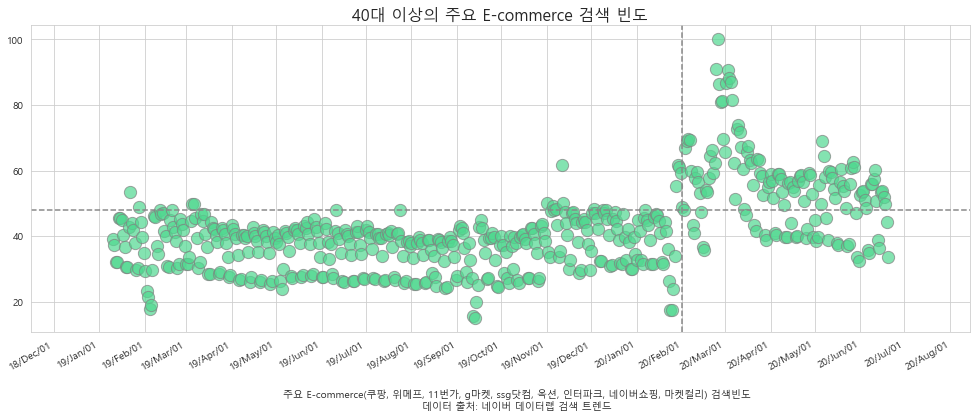

In [74]:
import datetime
import matplotlib.dates as mdates
start = datetime.datetime(2019,1,10)
end = datetime.datetime(2020,6,20)
dates_list = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days+1)]

fig,ax = plt.subplots(1,1,figsize=(15,6))
ax.scatter(dates_list, search_online['인터넷 쇼핑'], color=pal[0], alpha=0.7, edgecolor='gray', s=150)
ax.axhline(48, color=pal[2], linestyle='--')
ax.axvline('2020-02-01', color=pal[2], linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%b/%d'))
for label in ax.get_xticklabels():
        label.set_rotation(30); label.set_fontsize(10)
        label.set_horizontalalignment('right')

plt.title('40대 이상의 주요 E-commerce 검색 빈도', fontsize=16)
plt.suptitle('주요 E-commerce(쿠팡, 위메프, 11번가, g마켓, ssg닷컴, 옥션, 인터파크, 네이버쇼핑, 마켓컬리) 검색빈도\n데이터 출처: 네이버 데이터랩 검색 트렌드', 
             fontsize=10, position=(.5, 0.08))
plt.subplots_adjust(left=0.05, top = 0.92, right=0.92, wspace=0.05, bottom=0.21)

또 한, 네이버 데이터랩의 검색 트렌드에 의하면, 40대 이상의 쿠팡, 위메프, G마켓 등의 E-commerce 검색 빈도가 코로나 대확산 기간 이후에 확실히 증가한 것을 확인할 수 있습니다. 특히, 코로나 대확산 기간에 검색 빈도가 크게 상승했는데요. 코로나 기간이 없었더라면 오랜 시간동안 천천히 상승했을 E-commerce의 입지가, 코로나 대확산을 계기로 한 단계 바로 점프한 것으로 보입니다. 물론 네이버 검색 빈도가 직접적인 매출에 대한 데이터인 것은 아니지만, MZ세대보다 중장년층일수록 네이버에 검색해서 E-Commerce 사이트에 접속할 가능성이 더 높을 것으로 보기에, **구매력이 강한 40대 이상 연령대에게 E-commerce 마켓들이 편리하고 필수적인 존재로 인식되는 가장 큰 계기**가 된 것이라고 충분히 볼 수 있지 않을까 싶습니다.

한편, 검색빈도가 한 단계 점프한 또 다른 비대면 서비스가 바로 **OTT(Over The Top, 인터넷을 통해 볼 수 있는 TV 서비스)** 입니다.

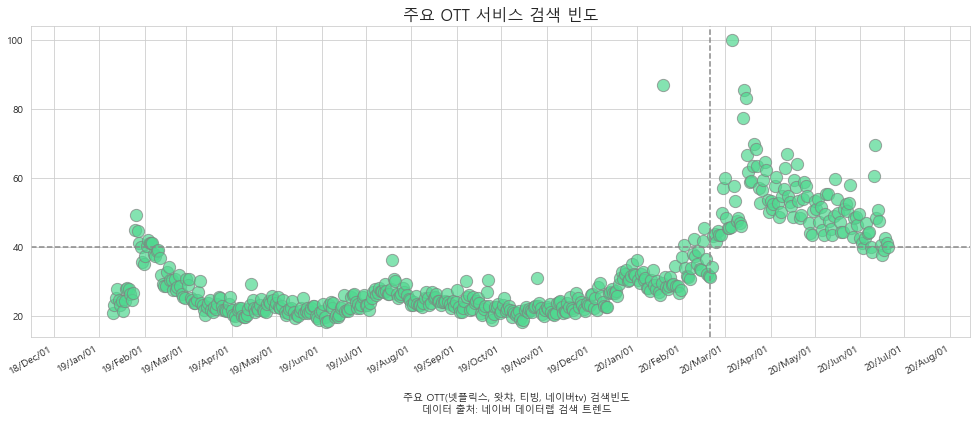

In [75]:
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax.scatter(dates_list, search_ott['OTT'], color=pal[0], alpha=0.7, edgecolor='gray', s=150)
ax.axhline(40, color=pal[2], linestyle='--')
ax.axvline('2020-02-20', color=pal[2], linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%b/%d'))
for label in ax.get_xticklabels():
        label.set_rotation(30); label.set_fontsize(10)
        label.set_horizontalalignment('right')

plt.title('주요 OTT 서비스 검색 빈도', fontsize=16)
plt.suptitle('주요 OTT(넷플릭스, 왓챠, 티빙, 네이버tv) 검색빈도\n데이터 출처: 네이버 데이터랩 검색 트렌드', 
             fontsize=10, position=(.5, 0.07))
plt.subplots_adjust(left=0.05, top = 0.92, right=0.92, wspace=0.05, bottom=0.2)

코로나 대확산 시기에 네이버 OTT 검색 빈도가 급격히 증가한 것을 볼 수 있었습니다. 실제로, 서울경제 기사 ["넷플릭스 코로나19 기간 1억 시간 시청 늘었다"](https://www.sedaily.com/NewsVIew/1Z2LVOINKW)에 따르면, 올해 1~4월의 국내 넷플릭스 이용 시간이 전년 동기 대비 1억 시간 늘어났다고 합니다. 또 한, 서울경제 기사 ["코로나에 실버세대도 넷플릭스·배민에 빠졌다"](https://www.sedaily.com/NewsVIew/1Z5EYL5UQ1)에 따르면, 라이나전성기재단에서 전국 거주 만 49세 이상의 회원 1,205명을 대상으로 설문조사한 결과, 응답자의 56.3%가 코로나19 이후 스마트폰을 보는 시간이 늘어났으며, 응답자의 38.5%는 코로나19 이후 유튜브나 넷플릭스 등의 영상 서비스를 처음으로 이용하게 되었다고 답했다고 합니다.

코로나 대확산이, 특히 **중장년층 연령대가, 온라인 상거래 및 온라인 비디오 스트리밍 등의 서비스에 관심을 가지고 진입하게 된 계기가 된 것 같습니다.** 


---

## 4.2. 회복이 더딘 대표 오프라인 산업들

한편, 코로나로 인해 타격을 받고 그 뒤로도 회복이 잘 안되고 있는 업종들 또한 존재합니다. 바로 ``1,2,특급 호텔, 항공사, 관광여행, 외국인전용가맹점, 기념품 점, 면세점`` 등의 **관광** 관련 업종과 ``문화취미기타, 기타레져업, 수영장, 영화관`` 등의 **문화 및 놀거리** 관련 산업입니다.

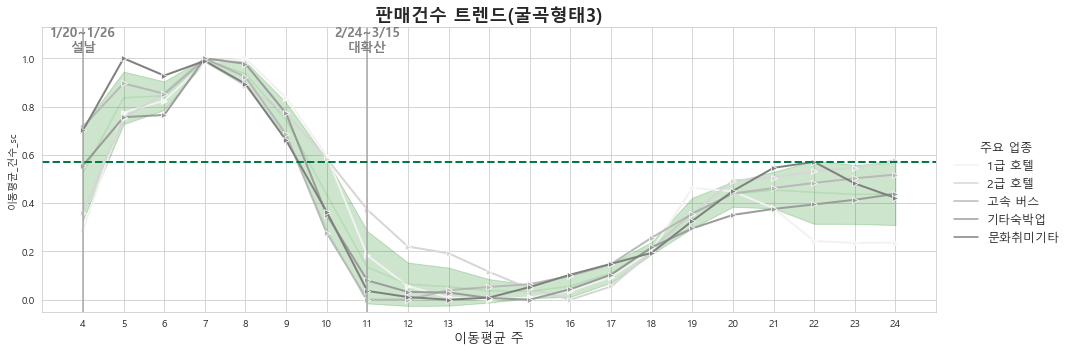

In [76]:
plot_trend(ind3_2, title="굴곡형태3")
plt.axhline(0.57, linewidth=2, linestyle='--', c=pal[1])
plt.tight_layout()

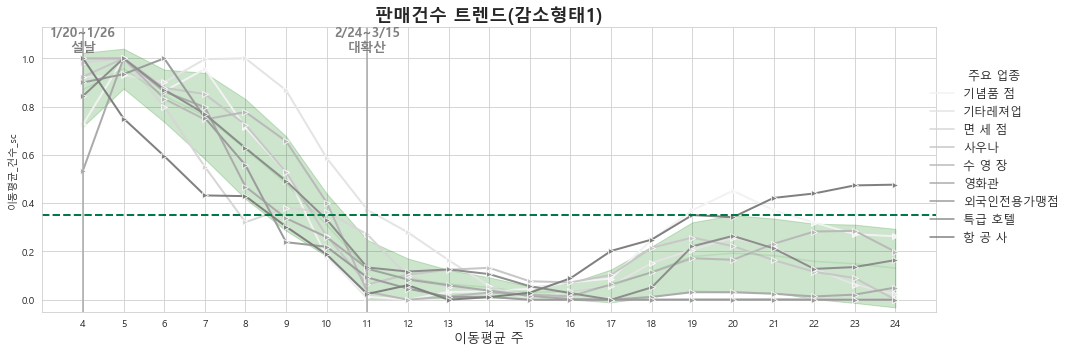

In [77]:
plot_trend(ind3_3, title="감소형태1")
plt.axhline(0.35, linewidth=2, linestyle='--', c=pal[1])
plt.tight_layout()

회복 기간 또한 유동인구보다 길거나, 해당 기간동안 회복이 되지 못한 업종들입니다.

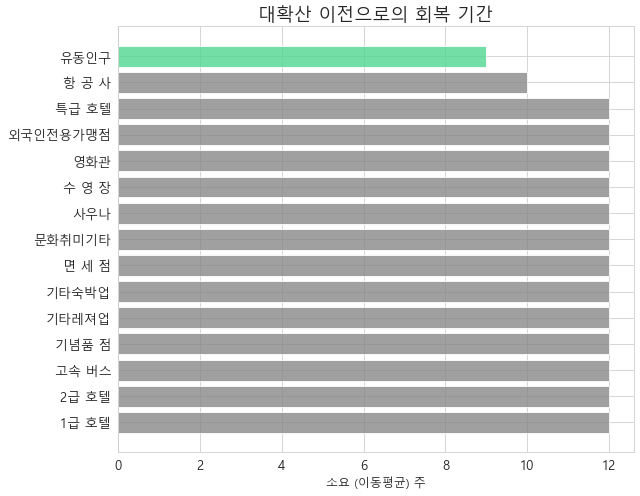

In [78]:
recovery_versus_population(card_new_pivot, ind3_2+ind3_3, size=(9,7))

### 멀어져가는 세계화와 피해가 큰 관광 산업

코로나가 가져온 가장 큰 시대 변화 중 하나가 바로 나라 간 왕래가 끊어졌다는 것이 아닐까 싶습니다. 특히, 아시아 관광객으로 붐볐던 명동 거리 역시 굉장히 한산해진 것을 볼 수 있는데요. 한국관광공사에서 2019년, 2020년의 1월부터 5월까지 외래 관광객 수와 관광 수입 데이터를 얻었습니다.

In [79]:
tour_num['년도'] = tour_num['시점'].astype('str').apply(lambda x: x[:4])
tour_num['월'] = tour_num['시점'].astype('str').apply(lambda x: x[4:6]).astype('int')
tour_num = tour_num[tour_num['월']<6].reset_index(drop=True)
tour_num = pd.pivot(tour_num, index='월',columns='년도', values='관광(명)')

tour_money['년도'] = tour_money['시점'].astype('str').apply(lambda x: x[:4])
tour_money['월'] = tour_money['시점'].astype('str').apply(lambda x: x[4:]).astype('int')
tour_money = tour_money[tour_money['월']<6]

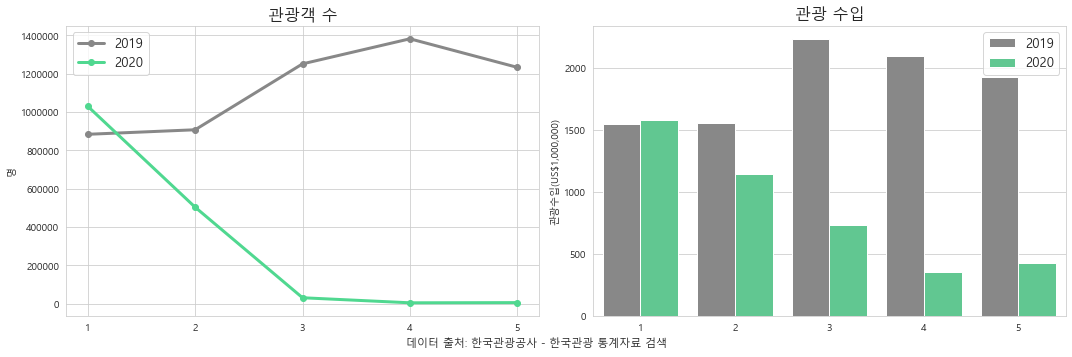

In [80]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(tour_num.index, tour_num['2019'], label='2019', color=pal[2], linewidth=3, marker='o')
ax[0].plot(tour_num.index, tour_num['2020'], label='2020', color=pal[0], linewidth=3, marker='o')
ax[0].set_title('관광객 수',fontsize=16)
ax[0].set_ylabel('명')
ax[0].set_xticks(list(range(1,6)))
ax[0].legend(fontsize=13)

sns.barplot(x='월', y='관광수입(US$1,000,000)', hue='년도', palette={'2020':pal[0], '2019':pal[2]}, data=tour_money, ax=ax[1])
ax[1].set_title('관광 수입', fontsize=16)
ax[1].set_xlabel(' ')
plt.suptitle('데이터 출처: 한국관광공사 - 한국관광 통계자료 검색', fontsize=11, position=(.5, 0.05))
plt.legend(fontsize=13)
plt.tight_layout()

위 플롯을 보면, 2019년 동월 대비 2020년 외래 관광객 수와 관광 수입 모두 2월부터 급감한 것을 확인할 수 있습니다. 다른 나라에서는 마스크를 착용하는 것이 정치적인 이슈가 될 정도로, 전세계적으로 확진자 수가 좀처럼 줄지 않는 상황입니다. 따라서, 나라 간 왕래가 자유로워지기까지는 정말 많은 시간이 걸릴 것으로 보입니다. 따라서 관광객을 대상으로 비대면으로 할 수 있는 활동 또는 비대면으로 관광 수입을 증진할 방안 등을 하루 빨리 고찰해야 합니다. 이를 위해 **나라별 비중**도 확인해보았는데요.

In [81]:
tour_nation = pd.read_excel('data/외래객입국_목적별_국적별.xlsx',encoding='UTF-8') #한국관광 통계자료 검색(관광수지_관광수입)
tour_nation['년도'] = tour_nation['시점'].astype('str').apply(lambda x: x[:4])
tour_nation['월'] = tour_nation['시점'].astype('str').apply(lambda x: x[4:6]).astype('int')
tour_nation = tour_nation[tour_nation['월']<6]
tour_nation = tour_nation.groupby('년도').sum().reset_index()

tour_nation['나머지'] = tour_nation.iloc[:,5] - tour_nation.iloc[:,2:5].sum(axis=1)
tour_nation = tour_nation[['년도','대만(명)','일본(명)','중국(명)','나머지']]

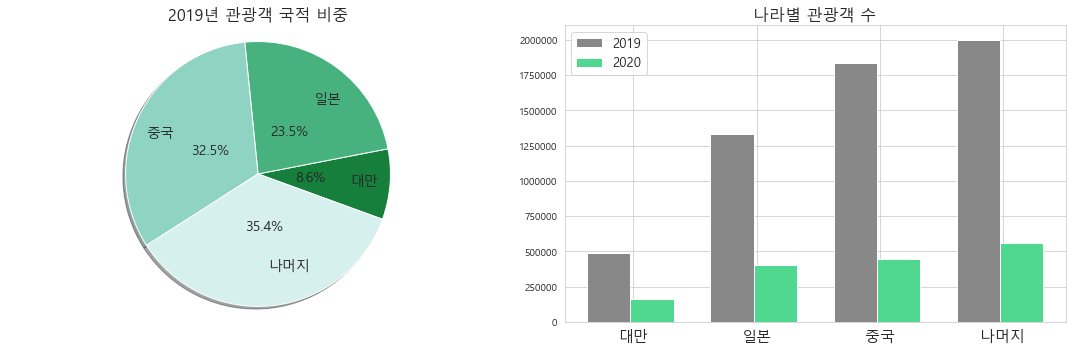

In [82]:
label = ['대만', '일본', '중국', '나머지']
size_2019 = tour_nation.iloc[0,1:]
size_2020 = tour_nation.iloc[1,1:]

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].pie(size_2019, labels=label, autopct='%1.1f%%', shadow=True, startangle=340,  textprops={'fontsize':14},
          labeldistance=0.7, pctdistance=0.4, colors=sns.color_palette('BuGn_r',len(label)))
ax[0].axis('equal')  
ax[0].set_title('2019년 관광객 국적 비중',fontsize=16)

bar_width = 0.35
index = np.arange(len(label))
ax[1].bar(index, size_2019, bar_width, color=pal[2], label='2019')
ax[1].bar(index+bar_width, size_2020, bar_width, color=pal[0],  label='2020')
ax[1].legend(fontsize=13)
ax[1].set_title('나라별 관광객 수', fontsize=16)
plt.xticks(index+0.2, label, fontsize=15)
plt.tight_layout()

2019년 관광객의 국적 비중을 확인하면, 중국이 약 1/3을 차지하고 있고, 그 다음으로는 일본이 가장 많았습니다. 즉, 주요 중국, 일본, 대만의 세 아시아 국가가 우리나라 관광객의 약 65%를 차지하고 있습니다. 한류 열풍과 아시아 관광객의 비중을 고려할 때, 아시아 관광객을 타게팅하는 방안이 효과적일 것으로 보입니다. 



---

# SUGGESTION

---

# 1. 인사이트에서 얻은 물음의 답: 라이브 카머스

지금까지 데이터에서 발견했던 인사이트와 그에 대한 물음을 정리하면 다음과 같습니다.

**1. 보복성 소비: 주요 소비의 증가는 지속될 수 있을까?**   
주요 업종에서 유동인구가 회복하는 추세보다도 빠르게 소비가 증가하였는데, 이는 일시적인 현상일 우려가 있다. 

- 포스트 코로나 시대, 단기로 끝날 수 있는 소비의 증가를 어떻게 지속시킬 수 있을까?  

**2. 소수에게만 해당되는 '배달'이라는 돌파구**  
유동인구 증가추세에 비해 배달의 감소추세는 느리다. 한편, 배달을 포함한 외식업의 회복력은 커지지만, 배달이 들어오는 데만 들어온다.
- 배달 시장이 감소하지 않을 것으로 보이는 상황에서, 외식업종은 어떻게 자신을 효과적으로 홍보하고, 매출을 올릴 수 있을까?

**3. 소비의 양극화**  
사람들이 포스트 코로나 시대에 지갑을 닫기만 하는 것은 아니다. 그런데, **자신이 두는 가치** 등을 기준으로 소비를 **선택과 집중**하는 경향을 보인다.
- 각 업종은 이러한 사람들의 소비 취향을 반영하여 어떻게 자신만의 컨셉 및 홍보 전략을 효과적으로 세울 수 있을까?

**4. 희비교차가 엇갈리는 온/오프라인 산업**  
코로나 대확산이 구매력이 높은 연령대가  E-Commerce와 OTT에 진입 또는 더욱 관심을 가지게 되는 계기가 되었다.
- 반면, 나라간 왕래가 끊어진 상황이 장기화될 때, 관광 산업의 돌파구는 무엇일까?



앞으로의 유망 산업이자 이 물음들에 대한 공통적인 답이 될 수 있다고 생각하는 것은 바로, **“라이브 카머스의 적극 도입”** 입니다. 라이브 카머스(Live Commerce)란, **비디오 스트리밍(Video Streaming)과 e-commerce의 결합** 을 의미합니다. 예를 들어, 어떤 유튜버가 옷가게에서 라이브 방송을 하면서 시청자들과 소통하고 대신 옷을 입어보면서 시청자들의 구매를 유도하는 것이 해당됩니다. 주요 대기업 또는 몇몇 분야에서는 라이브 커머스의 활용을 이미 시작했지만, 일반 자영업자나 코로나로 인한 타격을 입은 업종일수록 라이브 카머스를 더욱 적극적으로 활용해야 한다고 생각합니다. 

### 라이브 카머스의 기대효과

- **많은 정보의 제공:** 앞으로 연령층을 막론하고 온라인에서 이루어지는 구매활동의 빈도는 갈수록 증가할 것입니다. 사람들은 온라인에서 구매를 할 때, 대면으로 구매하는 것보다 불확실성이 크기 때문에 많은 정보가 있는 업체 또는 상품을 선호합니다. 그런데, 이제 상품을 홍보할 때 실시간으로 이루어지는 영상을 이용한다면, 이미지 한 장보다는 훨씬 더 많은 정보를 제공할 것입니다. 따라서, 각 업종은 정보의 부족으로 인한 소비자들의 불신을 달래고, 자신의 상품을 홍보할 수 있는 기회를 잡을 수 있게 됩니다. 

- **소비 활동의 촉진:** 모바일 영상의 시대라고 해도 과언이 아닐 정도로, 유튜브, 넷플릭스 등의 OTT 이용이 갈수록 증가하고 있습니다. 특히 MZ세대에게 아무때나 핸드폰으로 영상을 보는 것은 습관일 정도로, 하루에도 정말 많은 영상을 접하게 됩니다. 이 때, 라이브 영상이라는 (이전의 홍보 매체들에 비해) 비교적 신뢰도 높은 상품에 대한 정보를, 모바일이라는 환경에서 사람들이 자주 접하게 된다면, 소비 활동을 촉진시키는 효과 역시 기대할 수 있게 됩니다. 

- **홍보 컨셉의 다양성**: 라이브 카머스의 정체성은 바로 사람들이 흥미를 가지고 시청하는 컨텐츠 영상이라는 것입니다. 이에 따라, 개성 있는 콘텐츠가 큰 무기가 됩니다. 따라서, 각 업종들은 자신이 가진 자본 하에서도 번뜩이는 아이디어를 통해 큰 홍보 효과를 누릴 수 있습니다.

# 2. 라이버 카머스의 활용 방안

구체적으로 라이브 카머스를 활용한 서비스를, 두가지 목적 **(1)자영업자들의 홍보 효과 증진, (2)관광수입의 증대** 에 따라 각각 생각해보았습니다. 

## 2.1. 손바닥 화개장터

화개장터라고 하면 왜인지 정이 가득한 공간이 연상됩니다. 할머니들이 나물 팔고 계실 때 엄청 필요하지 않아도 사드리고, 그걸 또 두둑히 얹어주시는 그런 이미지입니다. 앱서비스 손바닥 화개장터는 핸드폰으로 보는 정이 가득한 공간, 화개장터라는 의미이고, 자영업자들의 홍보 효과 및 수입 증진을 목표로 하고 있습니다. 이 서비스는 다음의 두가지 기능이 있는데요.

### 2.1.1. 휴먼 다큐 + 카머스

자영업자들이 라이브 카머스를 활용할 때에는 **시청자들의 감성을 자극하는 것**이 홍보 효과에 큰 도움이 될 것이라 생각합니다. 손바닥 화개장터는 해당 가게들의 작업과정 및 사연에 대한 짧은 길이의 휴먼 다큐를 방송하며, 소비자들의 공감 및 구매를 유도합니다. 예를 들어, 대구에서 코로나 대확산되던 시기에, 대구 자영업자들이 의료진들을 위해 무료 도시락을 제공한 이미지가 SNS 상에서 화제였는데요. 그 이미지는 많은 사람들의 마음을 움직였고, “확진자 잠잠해지거든, 가서 돈쭐을 내드려야겠네요” 등의 해당 가게의 음식에 대한 구매 의사도 댓글에서 많이 볼 수 있었습니다. 그 당시에 실제로 이를 방송하며 배달 등을 통해 구매를 받았다면, 해당 가게들도 선행에 대한 더욱 큰 보상을 얻을 수 있지 않았을까 생각합니다. 

<img src="https://raw.githubusercontent.com/Soohee410/Post-Corona-Visualization-Competition/master/img/market1.PNG" width="850">



### 2.1.2. 스트리머와 자영업자의 자유로운 매칭

한편, 특별한 사연이 없거나 자신이 등장하고 싶지 않은 가게들의 경우에는, 애초에 인터넷 방송을 하던 사람들(스트리머)에게 홍보 및 라이브 방송을 부탁하는 방법이 있을 것입니다. 그런데, 가게마다 홍보에 쓸 수 있는 자본이 천차만별이고, 스트리머도 구독자 및 팔로워 수 등 영향력이 천차만별입니다. 이 때, 손바닥 화개장터는 스트리머를 찾는 자영업자들과, 라이브 방송을 해줄 의향이 있는 스트리머들이 모여서 자유롭게 서로 동의할 수 있는 조건을 합의할 기회의 장을 마련합니다. 마치 과외 중개 서비스에서 과외를 받으려는 사람과 하려는 사람이 서로 합의하고 매칭하는 것과 같은 맥락입니다.

<img src="https://raw.githubusercontent.com/Soohee410/Post-Corona-Visualization-Competition/master/img/market2.PNG" width="900">


## 2.2. Live Korea Market

외국인 고객의 비율이 높았던 명동과 이태원 거리가 코로나 이후 정말 한산해졌습니다. 아시아의 한류 열풍과 아시아 관광객의 비중이 높다는 것을 감안하여, 앱서비스 Live Korea Market은 중국, 일본, 대만 등 주요 나라를 대상으로, 그들이 본국으로 돌아가도 우리나라 상품을 소비할 수 있도록 하는 것이 목표입니다. 이를 위해 라이브 카머스를 활용하기 위한 포인트로는, **시청자와 같은 나라의 사람이 스트리머 역할을 하는 것**이라고 생각했습니다! 예를 들어, 중국인이 우리나라 의류를 사려고 할 때, 의류 매장에서 방송을 하는 사람은 중국인인 것입니다. 외국의 물건을 직접 구매한다는 것은 비교적 리스크가 큰 일입니다. 자신의 체형에 맞지 않을 수도 있고, 문의하거나 환불하는 과정이 복잡하기 때문에 구매를 망설이게 됩니다.그런데 다른 중국인 여성이 실제 매장에서 옷을 입어보고 질문을 실시간으로 받으면서 정보를 알려준다면, 
망설였던 이유에 대한 고민들을 많이 해결할 수 있을 것이라고 생각합니다.

<img src="https://raw.githubusercontent.com/Soohee410/Post-Corona-Visualization-Competition/master/img/livekorea2.PNG" width="900">

---

여기까지 긴 글 읽어주셔서 감사합니다!!

# 참고 문헌

- ["혼술, 홈족에 주류규제까지 풀리자...주류업계 '희색'"](http://www.greenpostkorea.co.kr/news/articleView.html?idxno=117499), 그린포스트코리아 
- ["'골프 전성시대'… 코로나 특수에 골프 관련 산업 '활황'"](https://biz.chosun.com/site/data/html_dir/2020/06/30/2020063000574.html), 조선비즈 
- ["코로나 경제 위기라는데 멈추지 않는 명품 판매"](https://biz.chosun.com/site/data/html_dir/2020/06/13/2020061301392.html?utm_source=naver&utm_medium=original&utm_campaign=biz), 조선비즈 
- ["[경제쏙] "정신과 진료비 보다 싸다"?…보복소비의 심리학"](https://n.news.naver.com/article/214/0001050551?lfrom=kakao), MBC뉴스
- ["9·11 후 美경제 살린 '보복성 소비'···코로나도 잡을 수 있을까](https://news.joins.com/article/23771761), 중앙일보
- ["코로나 불황에도 롯데·신세계백화점이 ‘VIP 문턱’ 높인 까닭"](http://ilyo.co.kr/?ac=article_view&entry_id=374772), 일요신문 
- ["시장문은 닫았지만... 칠성야시장 상인들의 마음담은 도시락 전달"](http://www.dktimes.net/news/articleView.html?idxno=1413), 대경타임즈 
- ["5월 소비심리 넉 달 만에 상승… 한은 “회복세로 보긴 일러"](https://biz.chosun.com/site/data/html_dir/2020/05/25/2020052503084.html), 조선비즈 
- ["“매달 수천만원 적자, 더 못버텨”…유령도시 된 이태원·명동"](http://news.heraldcorp.com/view.php?ud=20200720000611), 헤럴드경제
- ["명동 화장품 매장 10곳 중 1곳 휴업... 강남 성형외과는 늘어"](https://biz.chosun.com/site/data/html_dir/2020/07/21/2020072102907.html?utm_source=naver&utm_medium=original&utm_campaign=biz ), 조선비즈 
- [“넷플릭스 코로나19 기간 1억 시간 시청 늘었다”](https://www.sedaily.com/NewsVIew/1Z2LVOINKW), 서울경제
- ["코로나에 실버세대도 넷플릭스·배민에 빠졌다"](https://www.sedaily.com/NewsVIew/1Z5EYL5UQ1), 서울경제
- ["라이브커머스로 진화하는 모바일 쇼핑"](https://news.appstory.co.kr/plan13468), 앱스토리
- ["OTT"](https://terms.naver.com/entry.nhn?docId=3579352&cid=59088&categoryId=59096), 네이버 지식백과 
- ["라이브 커머스"](https://terms.naver.com/entry.nhn?docId=5956360&cid=43667&categoryId=43667), 네이버 지식백과 